# __Research Question:__

What set of criteria is most important to the sucess of a mutual fund? What about amongst ETFs? Which type of fund is more successful overall can can the success of a fund be accurately predicted based on these observed criteria?

### Importing:

In [46]:
# imports and settings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from   sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency

import statsmodels.formula.api as smf
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.style.use('seaborn-poster')

### Data overview:

The file contains 24,821 Mutual Funds and 1,680 ETFs with general aspects (as Total Net Assets, management company and size), portfolio indicators (as cash, stocks, bonds, and sectors), returns (as yeartodate, 2020-11) and financial ratios (as price/earning, Treynor and Sharpe ratios, alpha, and beta). This data was scraped from Yahoo Finance by kaggle user Stefano Leone.

Link to dataset: https://www.kaggle.com/stefanoleone992/mutual-funds-and-etfs


In [47]:

df_mf=pd.read_csv('USData/Mutual Funds.csv')
df_etf=pd.read_csv('USData/ETFs.csv')


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (167,171) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [48]:
print(df_mf.shape,'\n',df_mf.columns)

(24821, 173) 
 Index(['fund_symbol', 'fund_extended_name', 'fund_family', 'inception_date',
       'category', 'rating', 'return_rating', 'risk_rating',
       'investment_strategy', 'investment_type',
       ...
       'fund_sharpe_ratio_5years', 'category_sharpe_ratio_5years',
       'fund_sharpe_ratio_10years', 'category_sharpe_ratio_10years',
       'fund_treynor_ratio_3years', 'category_treynor_ratio_3years',
       'fund_treynor_ratio_5years', 'category_treynor_ratio_5years',
       'fund_treynor_ratio_10years', 'category_treynor_ratio_10years'],
      dtype='object', length=173)


# __DATA CLEANING APPENDIX__:


Throwing away  4 completely empty columns in df_etf - ['category_return_2019', 'category_return_2018', 'category_return_2017', 'category_return_2016']:

In [49]:
empty_cols2 = [col for col in df_etf.columns if df_etf[col].isnull().all()]
df_etf.drop(empty_cols2,
        axis=1,
        inplace=True)



Throwing away the unnecessary columns that don't contain information useful to our analysis in both df_mf and df_etf:

In [50]:
throwaway_cols=[
    'quarters_up',
    'quarters_down',
    'top10_holdings',
    'years_up',
    'years_down',
    'currency'
]
df_mf.drop(columns=throwaway_cols,axis=1,inplace=True)
df_etf.drop(columns=throwaway_cols[2:],axis=1,inplace=True)

df_etf.to_csv('NoEmptiesETFs.csv',index=False)
df_mf.to_csv('NoEmptiesMutual Funds.csv',index=False)


Creating a method that allows us to isolate sections of each data frame based on keywords in their column names:

def str_to_float(dataFrame,colNames):
    '''
    This method converts the values of a specific column in a given dataframe from strings to floats
    '''
    for x in dataFrame[colNames]:
        if type(x) == str:
            if ',' in x:
                x = x.replace(',', '')
            f = float(x)
            x = f
        if type(x) != float:
             print("wrong")


In [51]:
### Creates and returns a subset of df_mf by keeping only the columns with 'keyword' in their column name. 
def cleanbykeyword(df,keyword):
    """
    Searches and creates a list of all of the column names in df that contain the keyword.
    Subsets the df according to this list, then creates a df_new dataframe with this 
    information and drops the corresponding columns from the original df.

    Arguments:
        df: Dataset pandas DataFrame.
        cols: List of columns to be included in calculations. 
        keyword: Word to be removed from column name in order to preserve clarity with labeling.
        
        
    Return: dataframe containing data matching keyword.
    """
    col_list=[ i for i in df.columns if (keyword in i)] 
    #print(col_list)
    df_new=df[col_list]
    df.drop(columns=col_list,axis=1,inplace=True) #removes duplicate data from df_mf masterframe
    df_new.insert(0,'fund_symbol',df.fund_symbol) #inserts the fund symbols as the 1st column of the new data set
    return (df_new)

Removing category data from the dataframe. Some of the category columns were not updated properly in the data set and therefore cannot be used in our analyses, we drop them to save space: 


In [52]:
df_mf_category_data=cleanbykeyword(df_mf,'category_')
df_etf_category_data=cleanbykeyword(df_etf,'category_')
df_mf_category_data.head(4)

,fund_symbol,category_net_annual_expense_ratio,category_return_ytd,category_return_1month,category_return_3months,category_return_1year,category_return_3years,category_return_5years,category_return_10years,category_return_2019,...,category_r_squared_10years,category_standard_deviation_3years,category_standard_deviation_5years,category_standard_deviation_10years,category_sharpe_ratio_3years,category_sharpe_ratio_5years,category_sharpe_ratio_10years,category_treynor_ratio_3years,category_treynor_ratio_5years,category_treynor_ratio_10years
0,AAAAX,1.01,-5.47,-1.49,-1.00,-2.08,1.10,3.97,4.61,16.10,...,0.89,0.12,0.10,0.10,0.00,0.00,0.00,-0.00,0.03,0.04
1,AAADX,0.82,0.07,-1.33,-0.15,3.88,4.90,6.23,7.13,19.23,...,0.92,0.12,0.10,0.09,0.00,0.01,0.01,0.03,0.05,0.06
2,AAAGX,1.04,17.54,-2.64,1.64,25.92,15.98,14.64,14.19,31.90,...,0.88,0.19,0.16,0.15,0.01,0.01,0.01,0.14,0.13,0.13
3,AAAIX,0.73,-2.67,-1.46,0.19,1.83,3.98,6.21,7.46,21.35,...,0.93,0.15,0.12,0.11,0.00,0.00,0.01,0.02,0.04,0.05


## Fixing Treynor column

In [53]:
cleanbykeyword(df_mf,'treynor')
cleanbykeyword(df_etf,'treynor')

,fund_symbol,fund_treynor_ratio_3years,fund_treynor_ratio_5years,fund_treynor_ratio_10years
0,1305,3.92,8.01,9.29
1,1306,3.94,8.03,9.33
2,1308,3.93,8.03,9.31
3,1310,1.00,4.08,6.18
4,1311,1.02,4.10,6.24
...,...,...,...,...
1675,ZGBR,-8.94,-4.46,0.00
1676,ZHOK,0.00,0.00,0.00
1677,ZJPN,0.41,5.56,0.00
1678,ZMLP,-8.79,-8.72,0.00


df_mf.dropna(subset=['fund_treynor_ratio_3years','fund_treynor_ratio_5years','fund_treynor_ratio_10years'],inplace=True)
df_etf.dropna(subset=['fund_treynor_ratio_3years','fund_treynor_ratio_5years','fund_treynor_ratio_10years'],inplace=True)


#converting treynor columns from strings to floats ETF 
df_mf['fund_treynor_ratio_3years'] = str_to_float(df_mf,'fund_treynor_ratio_3years')
#df_etf_ratios['category_treynor_ratio_3years'] = str_to_float(df_etf_ratios,'category_treynor_ratio_3years')
df_mf['fund_treynor_ratio_5years'] = str_to_float(df_mf,'fund_treynor_ratio_5years')
#df_etf_ratios['category_treynor_ratio_5years'] = str_to_float(df_etf_ratios,'category_treynor_ratio_5years')
df_mf['fund_treynor_ratio_10years'] = str_to_float(df_mf,'fund_treynor_ratio_10years')
#df_etf_ratios['category_treynor_ratio_10years'] = str_to_float(df_etf_ratios,'category_treynor_ratio_10years')

#converting treynor columns from strings to floats MUTUAL FUNDS  
df_etf['fund_treynor_ratio_3years'] = str_to_float(df_etf,'fund_treynor_ratio_3years')
#df_mf_ratios['category_treynor_ratio_3years'] = str_to_float(df_mf_ratios,'category_treynor_ratio_3years')
df_etf['fund_treynor_ratio_5years'] = str_to_float(df_etf,'fund_treynor_ratio_5years')
#df_mf_ratios['category_treynor_ratio_5years'] = str_to_float(df_mf_ratios,'category_treynor_ratio_5years')
df_etf['fund_treynor_ratio_10years'] = str_to_float(df_etf,'fund_treynor_ratio_10years')
#df_mf_ratios['category_treynor_ratio_10years'] = str_to_float(df_mf_ratios,'category_treynor_ratio_10years')




In [54]:
#Saves copies with cleaned treynor ratio for future use
df_mf2=df_mf3=df_mf.copy()
df_etf2=df_etf3=df_mf.copy()

Cleaning by fund return:


In [55]:
df_mf_return_history=cleanbykeyword(df_mf,'_return_')
df_etf_return_history=cleanbykeyword(df_etf,'_return_').dropna()

df_etf_return_history.to_csv('returnsETFs.csv',index=False)
df_mf_return_history.to_csv('returnsMutual Funds.csv',index=False)

#Adds fund_return_ytd column to main datafrme and removes from return history subframe
df_mf['fund_return_ytd']=df_mf_return_history['fund_return_ytd']
df_etf['fund_return_ytd']=df_etf_return_history['fund_return_ytd']
df_mf_return_history=df_mf_return_history.drop(columns=['fund_return_ytd'])
df_etf_return_history=df_etf_return_history.drop(columns=['fund_return_ytd'])

df_etf_return_history.head(2)

,fund_symbol,fund_return_1month,fund_return_3months,fund_return_1year,fund_return_3years,fund_return_5years,fund_return_10years,fund_return_2019,fund_return_2018,fund_return_2017,fund_return_2016,fund_return_2015,fund_return_2014,fund_return_2013,fund_return_2012,fund_return_2011,fund_return_2010,fund_mean_annual_return_3years,fund_mean_annual_return_5years,fund_mean_annual_return_10years
54,1557,4.76,3.35,12.84,10.15,9.77,13.04,31.29,-4.45,21.69,11.80,1.34,13.53,32.21,15.84,2.06,14.93,0.93,0.87,1.10
117,AAXJ,1.85,5.02,15.34,3.46,8.94,4.30,17.40,-14.81,40.52,4.83,-9.85,3.93,2.48,21.39,-20.01,15.53,0.43,0.81,0.47


Removing quarterly data from return history

In [56]:
cleanbykeyword(df_mf_return_history,'_q')
cleanbykeyword(df_etf_return_history,'_q')
df_mf_return_history.columns

Index(['fund_symbol', 'fund_return_1month', 'fund_return_3months',
       'fund_return_1year', 'fund_return_3years', 'fund_return_5years',
       'fund_return_10years', 'fund_return_2019', 'fund_return_2018',
       'fund_return_2017', 'fund_return_2016', 'fund_return_2015',
       'fund_return_2014', 'fund_return_2013', 'fund_return_2012',
       'fund_return_2011', 'fund_return_2010',
       'fund_mean_annual_return_3years', 'fund_mean_annual_return_5years',
       'fund_mean_annual_return_10years'],
      dtype='object')

Cleaning by standard deviation:


In [57]:
df_mf_standard_deviations= cleanbykeyword(df_mf,'standard_deviation')
df_etf_standard_deviations=cleanbykeyword(df_etf,'standard_deviation')
df_etf_standard_deviations.to_csv('stdsETFs.csv',index=False)
df_mf_standard_deviations.to_csv('stdsMutual Funds.csv',index=False)

df_mf_standard_deviations.head(4)
df_etf_standard_deviations.head(4)

,fund_symbol,fund_standard_deviation_3years,fund_standard_deviation_5years,fund_standard_deviation_10years
0,1305,14.38,14.75,16.89
1,1306,14.38,14.75,16.83
2,1308,14.38,14.75,16.90
3,1310,15.16,16.21,18.39


Cleaning by net annual expense, Sharpe and Treynor Ratios:


In [58]:
df_mf_ratios=cleanbykeyword(df_mf,'_ratio')
df_etf_ratios=cleanbykeyword(df_etf,'_ratio')

df_etf_ratios.to_csv('ratiosETFs.csv',index=False)
df_mf_ratios.to_csv('ratiosMutual Funds.csv',index=False)
df_mf_ratios.head(4)
df_etf_ratios.head(4)



,fund_symbol,fund_net_annual_expense_ratio,price_earnings_ratio,price_book_ratio,price_sales_ratio,price_cashflow_ratio,fund_sharpe_ratio_3years,fund_sharpe_ratio_5years,fund_sharpe_ratio_10years
0,1305,0.00,12.92,1.18,0.81,5.41,0.34,0.59,0.60
1,1306,0.05,12.92,1.18,0.81,5.41,0.34,0.59,0.61
2,1308,0.00,12.92,1.18,0.81,5.44,0.34,0.59,0.60
3,1310,0.00,11.34,1.12,1.07,4.06,0.14,0.34,0.44


Cleaning by Alpha value:


In [59]:
df_mf_alpha=cleanbykeyword(df_mf,'alpha')
df_mf_alpha.head(4)
df_etf_alpha=cleanbykeyword(df_etf,'alpha')
df_etf_alpha.head(4)



,fund_symbol,fund_alpha_3years,fund_alpha_5years,fund_alpha_10years
0,1305,0.29,0.39,0.35
1,1306,0.31,0.40,0.38
2,1308,0.30,0.41,0.36
3,1310,-2.58,-3.41,-2.56


Cleaning by Beta value:


In [60]:
df_mf_beta=cleanbykeyword(df_mf,'beta')
df_mf_beta.head(4)
df_etf_beta=cleanbykeyword(df_etf,'beta')
df_etf_beta.head(4)



,fund_symbol,fund_beta_3years,fund_beta_5years,fund_beta_10years
0,1305,1.00,0.98,0.99
1,1306,1.00,0.98,0.98
2,1308,1.00,0.98,0.99
3,1310,1.04,1.06,1.06



Cleaning by Sector:


In [61]:
df_mf_sector=cleanbykeyword(df_mf,'sector')
df_etf_sector=cleanbykeyword(df_etf,'sector')

df_etf_sector.to_csv('sectorsETFs.csv',index=False)
df_mf_sector.to_csv('sectorsMutual Funds.csv',index=False)
df_etf_sector.head(4)

,fund_symbol,sector_basic_materials,sector_consumer_cyclical,sector_financial_services,sector_real_estate,sector_consumer_defensive,sector_healthcare,sector_utilities,sector_communication_services,sector_energy,sector_industrials,sector_technology
0,1305,7.81,17.26,11.73,3.19,9.44,7.05,1.96,4.95,1.7,20.29,14.61
1,1306,7.81,17.26,11.73,3.19,9.43,7.06,1.96,4.95,1.7,20.29,14.62
2,1308,7.74,17.33,11.57,3.22,9.53,7.07,1.99,4.98,1.7,20.23,14.62
3,1310,2.41,14.25,16.26,1.74,7.93,4.55,0.00,15.52,2.0,16.26,19.06


Cleaning by Credit:


In [62]:
df_mf_credit=cleanbykeyword(df_mf,'credit').dropna()
df_etf_credit=cleanbykeyword(df_etf,'credit').dropna()
df_mf_credit.to_csv('creditsMutual Funds.csv',index=False)
df_mf_credit.head(4)


,fund_symbol,credit_us_government,credit_aaa,credit_aa,credit_a,credit_bbb,credit_bb,credit_b,credit_below_b,credit_other_ratings
3,AAAIX,0.0,57.15,5.64,10.26,13.63,6.82,4.78,1.02,0.70
7,AAARX,0.0,57.15,5.64,10.26,13.63,6.82,4.78,1.02,0.70
9,AAATX,0.0,66.37,4.40,8.79,9.01,5.64,3.23,1.09,1.47
10,AAAUX,0.0,57.15,5.64,10.26,13.63,6.82,4.78,1.02,0.70


Cleaning by r squared coefficient:


In [63]:
df_mf_rsquare=cleanbykeyword(df_mf,'squared')
df_mf_rsquare.head(4)
df_etf_rsquare=cleanbykeyword(df_etf,'squared')
df_etf_rsquare.head(4)



,fund_symbol,fund_r_squared_3years,fund_r_squared_5years,fund_r_squared_10years
0,1305,99.72,99.70,99.68
1,1306,99.72,99.69,99.68
2,1308,99.72,99.69,99.68
3,1310,96.51,97.19,96.63


Cleaning by asset:


In [64]:
df_mf_asset=cleanbykeyword(df_mf,'asset')
df_etf_asset=cleanbykeyword(df_etf,'asset')

df_etf_asset.to_csv('assetsETFs.csv',index=False)
df_mf_asset.to_csv('assetsMutual Funds.csv',index=False)
df_mf_asset.head(4)


,fund_symbol,asset_cash,asset_stocks,asset_bonds,asset_others,asset_preferred,asset_convertable,net_asset_value
0,AAAAX,1.88,63.87,15.31,18.95,0.00,0.00,6.979100e+08
1,AAADX,3.49,48.14,48.37,0.00,0.00,0.00,8.938000e+07
2,AAAGX,1.54,98.46,0.00,0.00,0.00,0.00,1.490000e+09
3,AAAIX,2.75,78.52,18.48,0.01,0.07,0.14,7.072500e+08


Merges datasets containing R-Squares, Alpha, and Beta values into a single data set:


In [65]:
df_mf_stats=df_mf_rsquare.merge(df_mf_alpha,how='left')
df_mf_stats=df_mf_stats.merge(df_mf_beta,how='left')
df_mf_stats.to_csv('statsMutual Funds.csv',index=False)
df_mf_stats.head()

df_etf_stats=df_etf_rsquare.merge(df_etf_alpha,how='left')
df_etf_stats=df_etf_stats.merge(df_etf_beta,how='left')
df_etf_stats.to_csv('statsETFs.csv',index=False)
df_etf_stats.head()




,fund_symbol,fund_r_squared_3years,fund_r_squared_5years,fund_r_squared_10years,fund_alpha_3years,fund_alpha_5years,fund_alpha_10years,fund_beta_3years,fund_beta_5years,fund_beta_10years
0,1305,99.72,99.70,99.68,0.29,0.39,0.35,1.00,0.98,0.99
1,1306,99.72,99.69,99.68,0.31,0.40,0.38,1.00,0.98,0.98
2,1308,99.72,99.69,99.68,0.30,0.41,0.36,1.00,0.98,0.99
3,1310,96.51,97.19,96.63,-2.58,-3.41,-2.56,1.04,1.06,1.06
4,1311,96.52,97.20,96.64,-2.56,-3.39,-2.50,1.04,1.06,1.06


# __EXPLORATORY ANALYSIS__

In [66]:
#creates a pie chart representing the relative distribution of funds in a certain category 
def pie_chart(df,column):
    '''
    Param df: Pandas dataframe
    Param column: column in df that is to be analyzed.
    '''
    grouped=df.groupby(column).fund_symbol.count().to_frame()
    plt.pie(grouped.fund_symbol,labels=grouped.index,autopct='%.2f%%')
    plt.show()

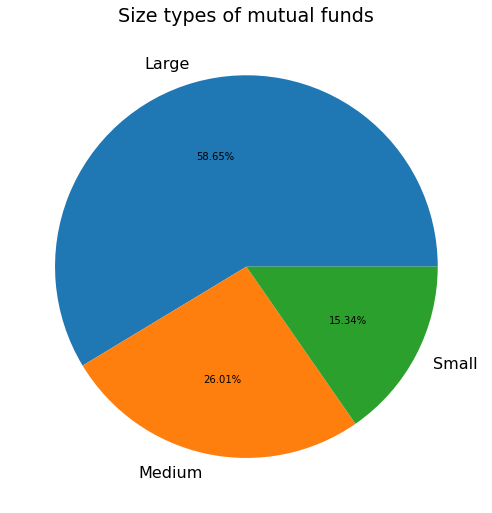

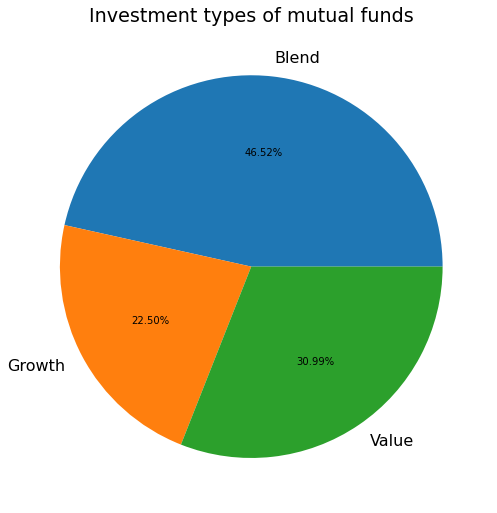

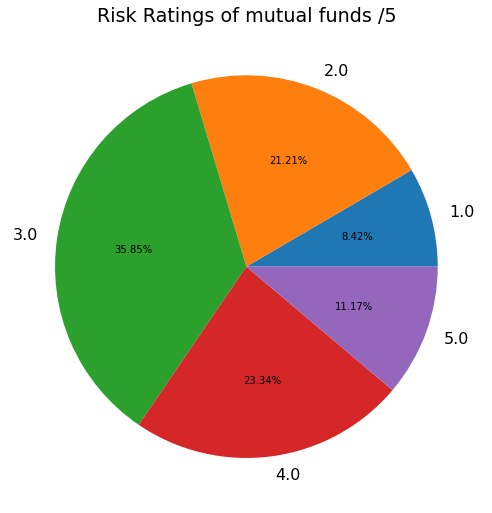

In [67]:
#Basic analysis of mutual fund distributions
plt.title('Size types of mutual funds')
pie_chart(df_mf,'size_type')
plt.title('Investment types of mutual funds')
pie_chart(df_mf,'investment_type')
plt.title('Risk Ratings of mutual funds /5')
pie_chart(df_mf,'risk_rating')


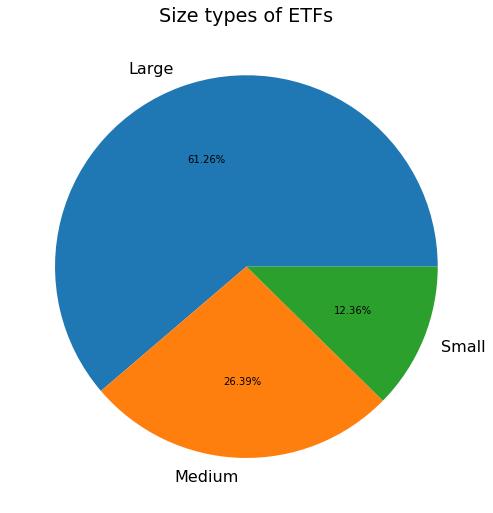

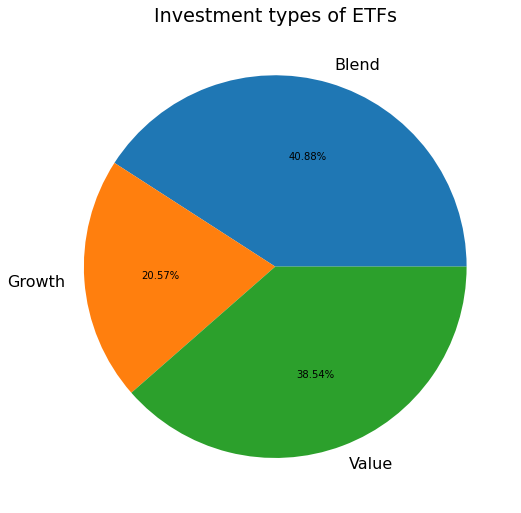

In [68]:
#Basic analysis of ETF distributions
plt.title('Size types of ETFs')
pie_chart(df_etf,'size_type')
plt.title('Investment types of ETFs')
pie_chart(df_etf,'investment_type')



In [69]:
#creats a pie chart representing the % composition of a certain range of values in a dataset.
def percent_comp_bar(df,cols,keyword):
    """
    Creates a pie chart for a given DataFrame subset. Each section in the pie chart
    represents a column mean within the dataframe, which corresponds to a % invested
    in a given category (sector/asset)
    
    Arguments:
        df: Dataset pandas DataFrame.
        cols: List of columns to be included in calculations. 
        keyword: Word to be removed from column name in order to preserve clarity with labeling.
    """
    col_names=[]
    other=0
    col_sums=[]
    for column in cols:
        col_sum=df[column].mean()
        if(col_sum<1 or 'other' in column):
            other+=col_sum
        else:
            col_names.append(column.replace(keyword,''))
            col_sums.append(df[column].mean())
    if(other>0.1):
        col_names.append('other')
        col_sums.append(other)
    plt.pie(col_sums,labels=col_names,autopct='%.2f%%') 
    plt.show()


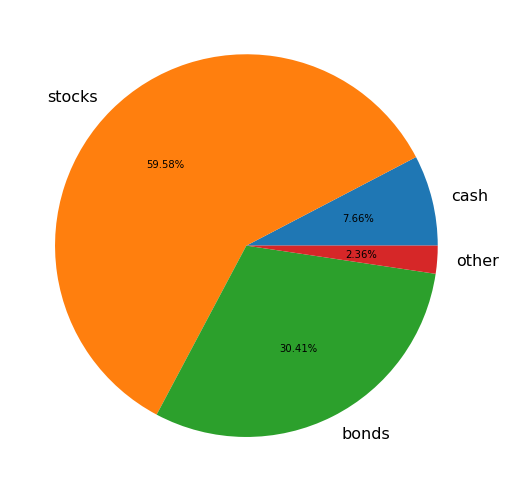

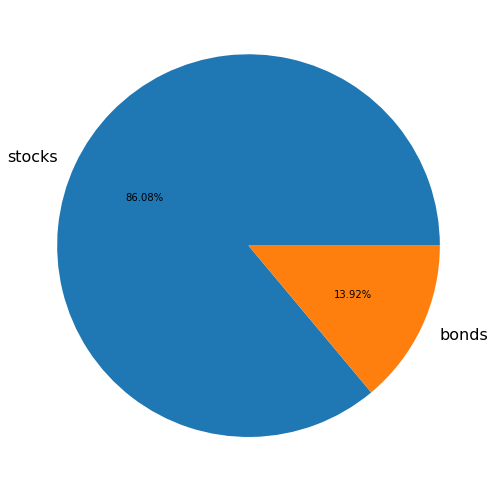

In [70]:
cols=[i for i in df_mf_asset.columns[1:7]]
percent_comp_bar(df_mf_asset,cols,'asset_')
cols=[i for i in df_etf_asset.columns[1:3]]
percent_comp_bar(df_etf_asset,cols,'asset_')

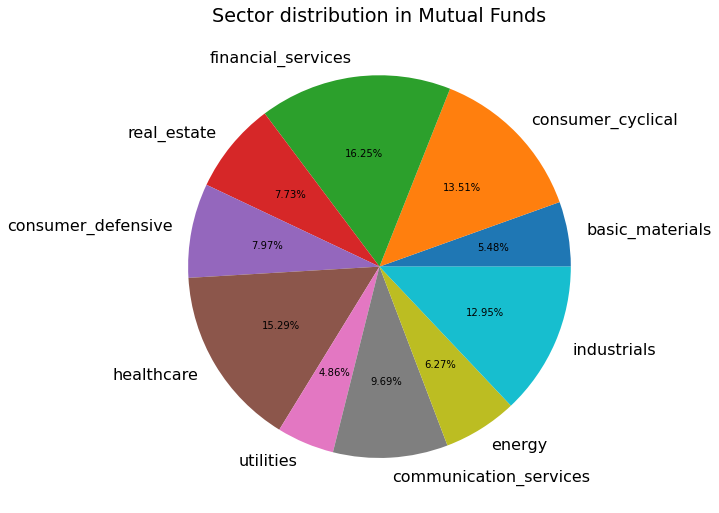

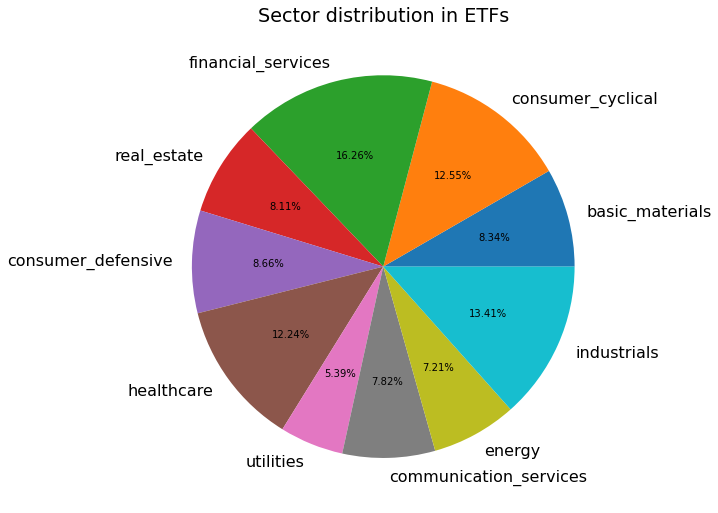

In [71]:
# Percentage invested in each sector
cols=[i for i in df_mf_sector.columns[1:11]]
plt.title('Sector distribution in Mutual Funds')
percent_comp_bar(df_mf_sector,cols,'sector_')
print('\n')
plt.title('Sector distribution in ETFs')
percent_comp_bar(df_etf_sector,cols,'sector_')


In [72]:
#Creates a bar plot of the 20 most common values in the given column
def distribution_by_category(df):
    '''
    Param df: dataframe of funds containing category type.
    
    '''
    cat_count=df['category'].value_counts()[:20]
    sns.barplot(x=cat_count.values,y=cat_count.index)
    plt.title('Distribution by Category')
    plt.tight_layout
    plt.show()

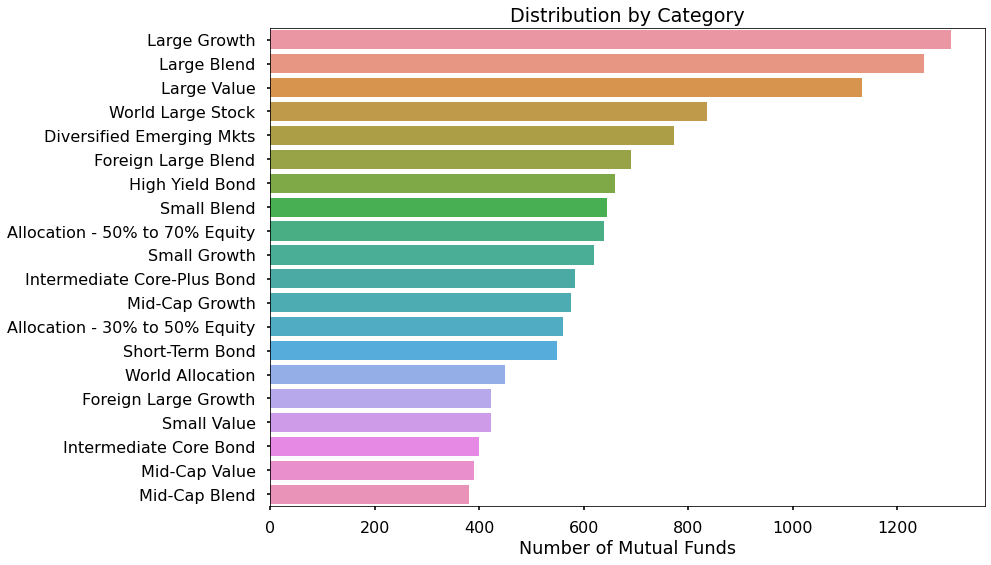

In [73]:
plt.xlabel('Number of Mutual Funds')
distribution_by_category(df_mf)

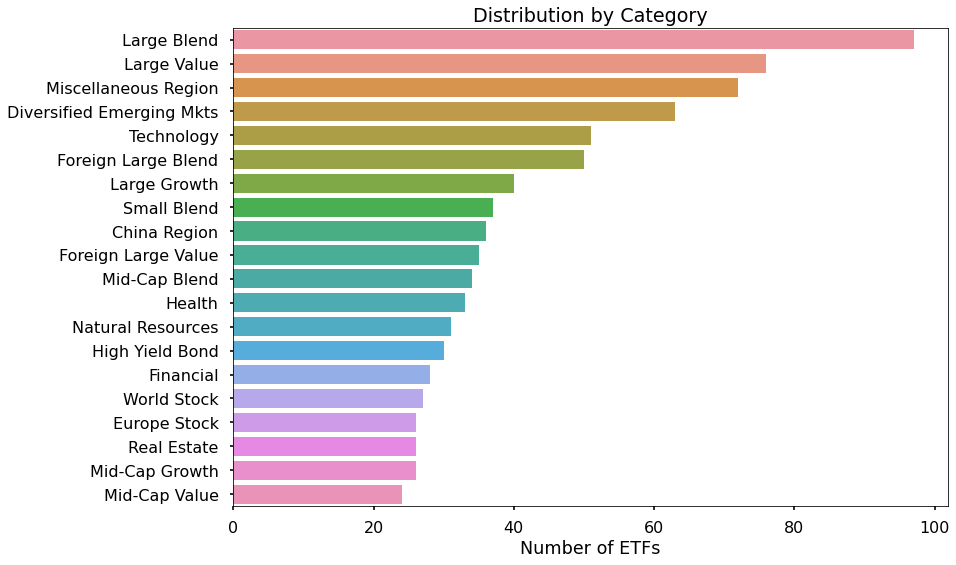

In [74]:
plt.xlabel('Number of ETFs')
distribution_by_category(df_etf)

In [75]:
#Draws a boxplot representing the dependent column as a function of the independent column
def dep_by_indep_boxplot(df_joined,independent,dependent,fundtype):
    '''
    Param df_joined: dataframe containing both the independent and dependent columns
    Param independent: column which serves as the independent variable
    Param dependent: column which serves as the dependent variable which is analyzed and plotted according to the dependent column.
    Param fundtype: Name of fund that is printed at the start of execution.
    '''
    
    print('\n Distribution of {} according to {} in {}'.format(dependent,independent,fundtype)+':\n')

    colors=['blue','grey','magenta','yellow','cyan','orange']    
    criteria=[i for i in df_joined[independent].sort_values(ascending=True).dropna().unique()]
    col_count=len(criteria)
    table=df_joined.melt(id_vars=[independent],value_vars=[dependent]).dropna()
    
    fig,ax=plt.subplots(nrows=1,ncols=col_count,figsize=(15,9))
    for i in range(0,col_count):
        sns.boxplot(data=table.where(table[independent]==criteria[i]).value,ax=ax[i],color=colors[i])
        ax[i].set_title(independent + ' = ' + str(criteria[i]))
        plt.tight_layout()
    plt.show()
    



 Distribution of price_earnings_ratio according to risk_rating in Mutual Funds:



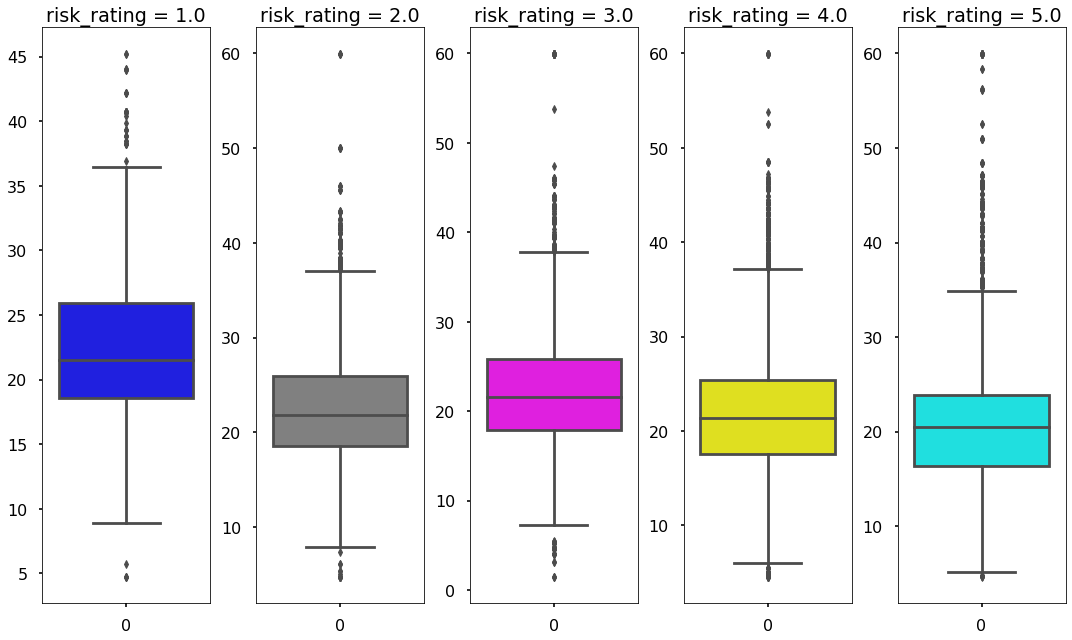

In [76]:
#Price earnings ratio vs. risk rating for Mutual Funds
joined=pd.merge(df_mf,df_mf_ratios)
dep_by_indep_boxplot(joined,'risk_rating','price_earnings_ratio','Mutual Funds')


 Distribution of fund_alpha_3years according to size_type in Mutual Fund:



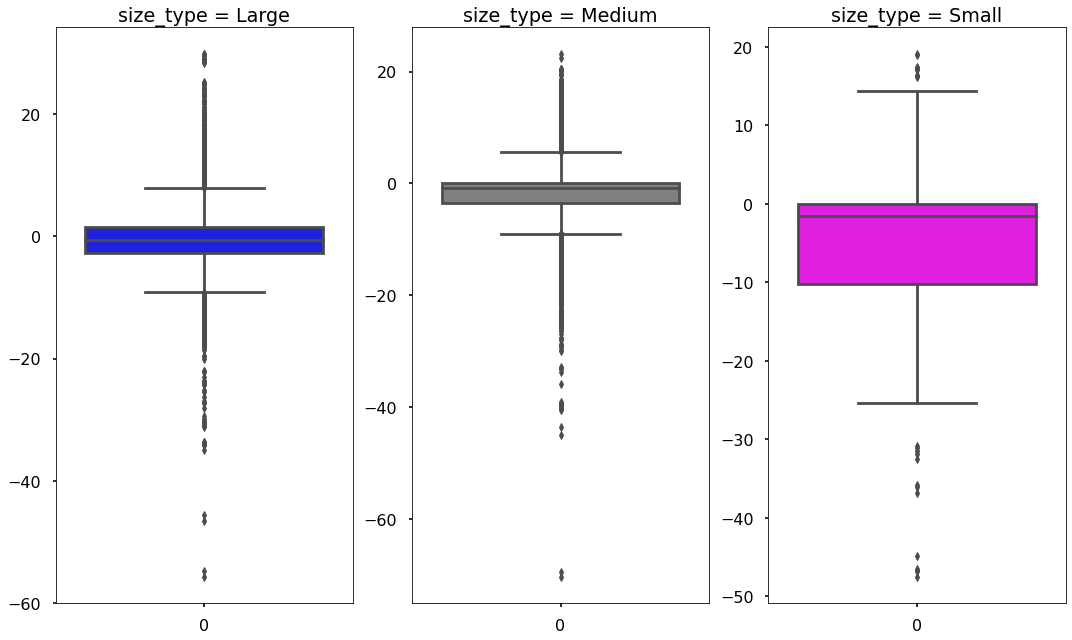

In [77]:
#Mutual Fund size vs. alpha 3 years value
joined=pd.merge(df_mf,df_mf_stats)
dep_by_indep_boxplot(joined,'size_type','fund_alpha_3years','Mutual Fund')



 Distribution of fund_alpha_3years according to size_type in ETFs:



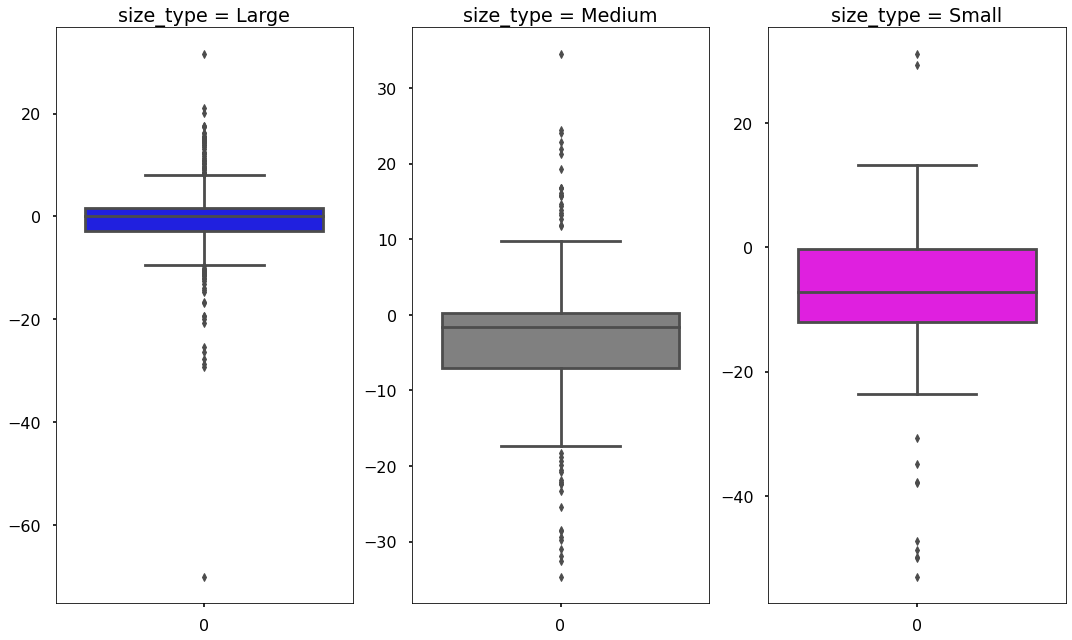

In [78]:
#ETF Fund size vs. alpha 3 years score
joined=pd.merge(df_etf,df_etf_stats)
dep_by_indep_boxplot(joined,'size_type','fund_alpha_3years','ETFs')


 Distribution of fund_return_ytd according to investment_type in Mutual Fund:



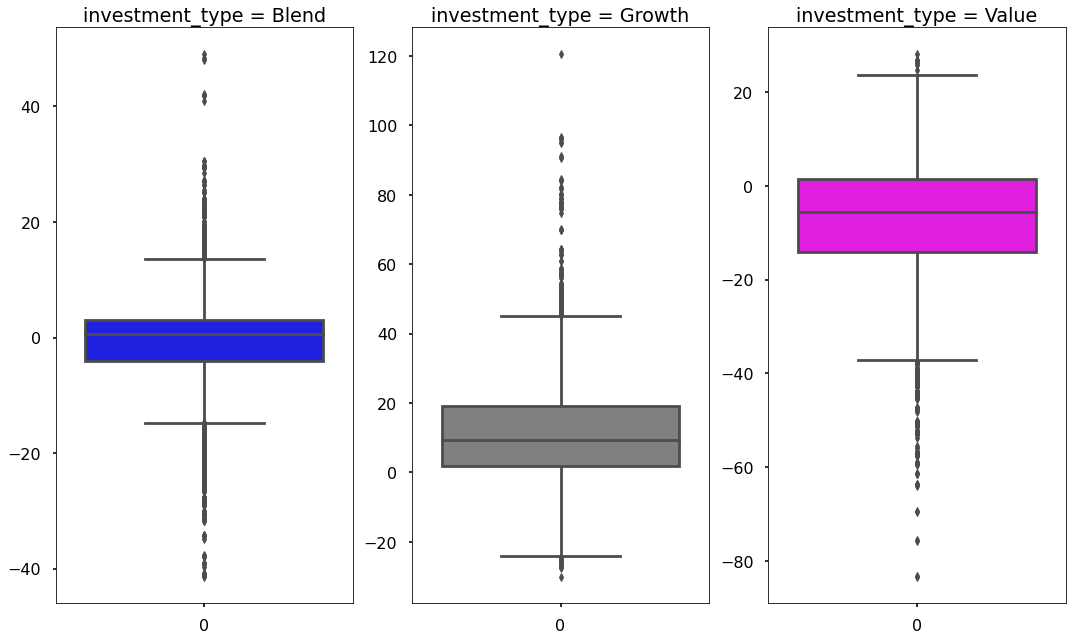

In [79]:
#Investment type vs. mutual fund YTD return
joined=pd.merge(df_mf,df_mf_return_history)
dep_by_indep_boxplot(joined,'investment_type','fund_return_ytd','Mutual Fund')


 Distribution of fund_return_ytd according to investment_type in ETFs:



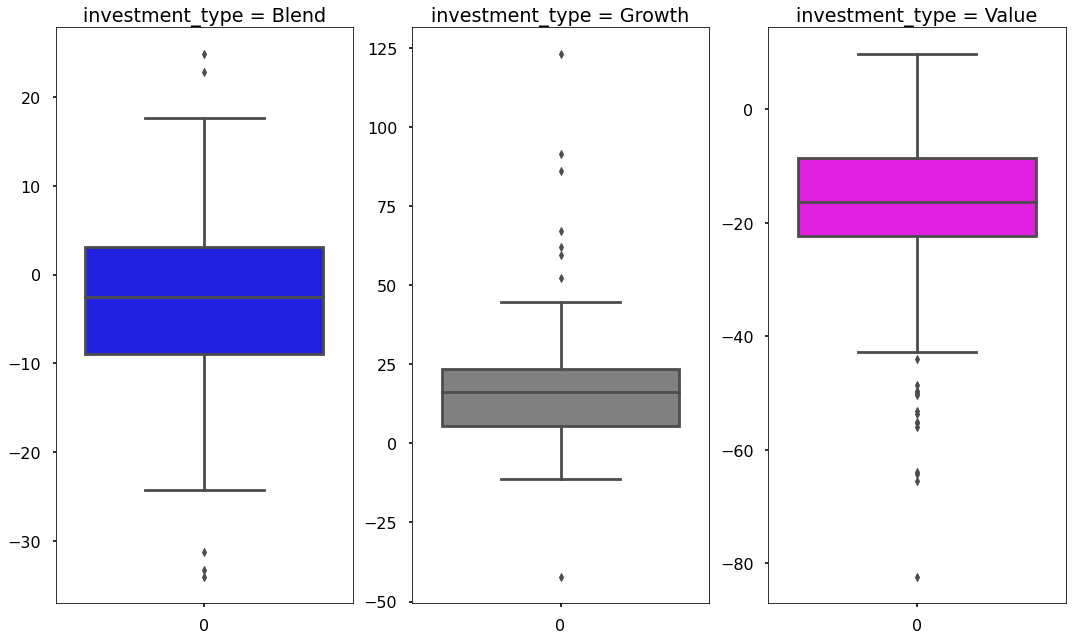

In [80]:
#Investment type vs. mutual fund YTD return
joined=pd.merge(df_etf,df_etf_return_history)
dep_by_indep_boxplot(joined,'investment_type','fund_return_ytd','ETFs')

# Start of Machine Learning:

# __Lin Reg analysis of Correlation:__


__Goal:  Use machine learning find out which variables are most correlated with fund_return_ytd among MFs and ETFs in the short, medium, and long term.___

In [81]:
#Removes NaNs from fund return column
df_mf.dropna(subset=['fund_return_ytd'],inplace=True)
df_etf.dropna(subset=['fund_return_ytd'],inplace=True)



### __Methods used:__

In [82]:
## returns a data frame of the correlations of the variables in the 'predictors' array with the 'independentVariable' in the data frame 'df'
def get_correlations(df,predictors,independentVariable):
    #Scaling columns with discrete variables
    #scaled = StandardScaler().fit_transform(df[predictors])
    #df[predictors]=scaled
    
    df_corr=pd.DataFrame(index=['correlation'],columns=predictors)
    for predictor in predictors:
        model=LinearRegression().fit(df[[predictor]],df[independentVariable])
        correlation=model.score(df[[predictor]],df[independentVariable])
        df_corr[predictor]=round(correlation,4)
        
    return df_corr.T

In [83]:
## Generates a bar plot of the correlations in the data frame 'df_corr' that have correlations greater than the value 'cutoff' 
## the plot is titled 'title' and has index labels of font size 'labelsize'
def corr_visualize(df_corr,cutoff,title,labelsize):
    df_cutoffs=df_corr[df_corr['correlation']>cutoff]
    sns.barplot(x=df_cutoffs.index,y=df_cutoffs['correlation'],palette='rocket')
    plt.title(title)
    plt.tick_params(labelsize=labelsize)
    plt.tight_layout()


In [84]:
## filters the correlations in the data frame 'df_corrs' and adds the correlations greater than .10
## pass in 'df_mf_highest_corrs' or 'df_etf_highest_corrs' in the variable 'df_high_corrs' for respective fund types
def filter_correlations(df_corrs,df_high_corrs,cutoff):
    for i in df_corrs.index:
        corr=df_corrs.loc[i,'correlation']
        if (corr>cutoff or corr <cutoff*-1):
                df_high_corrs[i]=corr

## __Putting it all together: Using get_correlations and corr_visualize to determine which variables are most correlated with fund_return_ytd for each type of fund__

In [85]:
df_mf3.head()

,fund_symbol,fund_extended_name,fund_family,inception_date,category,rating,return_rating,risk_rating,investment_strategy,investment_type,...,fund_mean_annual_return_10years,fund_r_squared_3years,fund_r_squared_5years,fund_r_squared_10years,fund_standard_deviation_3years,fund_standard_deviation_5years,fund_standard_deviation_10years,fund_sharpe_ratio_3years,fund_sharpe_ratio_5years,fund_sharpe_ratio_10years
0,AAAAX,DWS RREEF Real Assets Fund - Class A,DWS,2007-07-29,World Allocation,3.0,3.0,3.0,The investment seeks total return in excess of...,Blend,...,0.23,85.80,78.81,77.74,12.46,10.39,8.67,0.18,0.33,0.24
1,AAADX,Aberdeen Income Builder Fund Class A,Aberdeen,2011-12-29,Allocation - 50% to 70% Equity,4.0,5.0,5.0,The investment seeks income; long-term growth ...,Blend,...,0.92,87.23,84.28,89.77,8.46,10.21,11.70,0.93,0.74,0.89
2,AAAGX,Thrivent Large Cap Growth Fund Class A,Thrivent Funds,1999-10-28,Large Growth,3.0,3.0,4.0,The investment seeks long-term capital appreci...,Growth,...,1.25,90.82,85.84,87.04,19.81,16.49,15.40,0.92,0.88,0.93
3,AAAIX,American Century Strategic Allocation: Aggress...,American Century Investments,2000-07-31,Allocation - 70% to 85% Equity,4.0,4.0,3.0,The investment seeks the highest level of tota...,Blend,...,0.75,98.48,97.71,97.20,14.93,12.35,11.44,0.41,0.61,0.73
4,AAANX,Horizon Active Asset Allocation Fund Investor ...,Horizon Investments,2012-01-30,Tactical Allocation,3.0,4.0,5.0,The investment seeks capital appreciation. The...,Blend,...,NaN,95.21,94.66,NaN,18.26,15.06,NaN,0.17,0.37,NaN


# Example:

# Analysis of correlation with fund return
__Finding the correlation of different variables with fund_return_ytd in the short, medium, and long terms.__

In [86]:
#First instance of df_mf2,df_etf2
mf_short= cleanbykeyword(df_mf2,'3years').dropna()
mf_med= cleanbykeyword(df_mf2,'5years').dropna()
mf_long= cleanbykeyword(df_mf2,'10years').dropna()

etf_short= cleanbykeyword(df_etf2,'3years').dropna()
etf_med= cleanbykeyword(df_etf2,'5years').dropna()
etf_long= cleanbykeyword(df_etf2,'10years').dropna()


mf_long.columns

Index(['fund_symbol', 'fund_return_10years', 'fund_alpha_10years',
       'fund_beta_10years', 'fund_mean_annual_return_10years',
       'fund_r_squared_10years', 'fund_standard_deviation_10years',
       'fund_sharpe_ratio_10years'],
      dtype='object')

In [87]:
mf_short.head()

,fund_symbol,fund_return_3years,fund_alpha_3years,fund_beta_3years,fund_mean_annual_return_3years,fund_r_squared_3years,fund_standard_deviation_3years,fund_sharpe_ratio_3years
0,AAAAX,3.03,-2.51,1.09,0.31,85.80,12.46,0.18
1,AAADX,9.71,0.17,1.17,0.80,87.23,8.46,0.93
2,AAAGX,19.44,7.68,1.06,1.65,90.82,19.81,0.92
3,AAAIX,6.79,0.07,1.41,0.64,98.48,14.93,0.41
4,AAANX,3.04,-4.19,1.69,0.39,95.21,18.26,0.17


## SHORT TERM

['fund_alpha_3years', 'fund_beta_3years', 'fund_mean_annual_return_3years', 'fund_r_squared_3years', 'fund_standard_deviation_3years', 'fund_sharpe_ratio_3years']


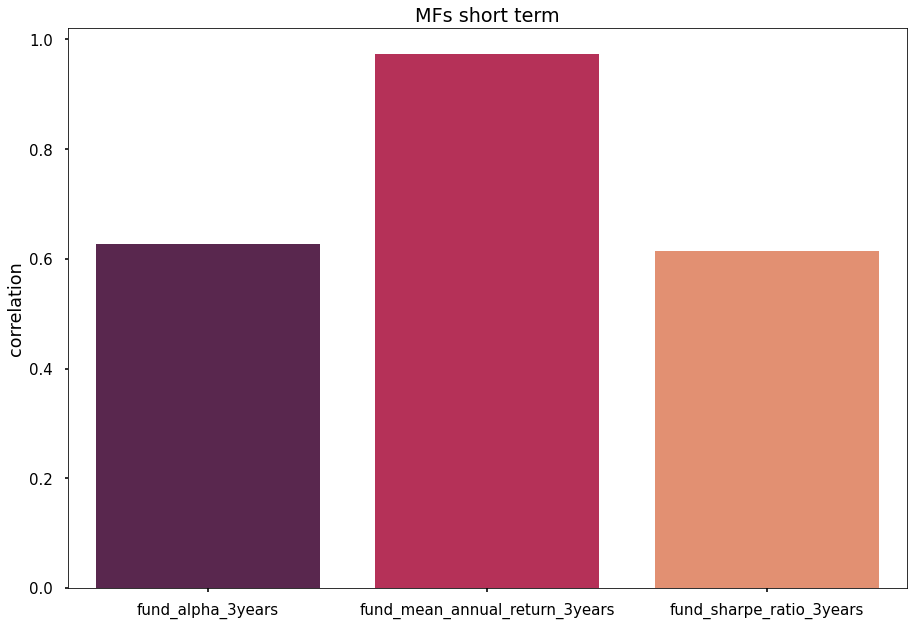

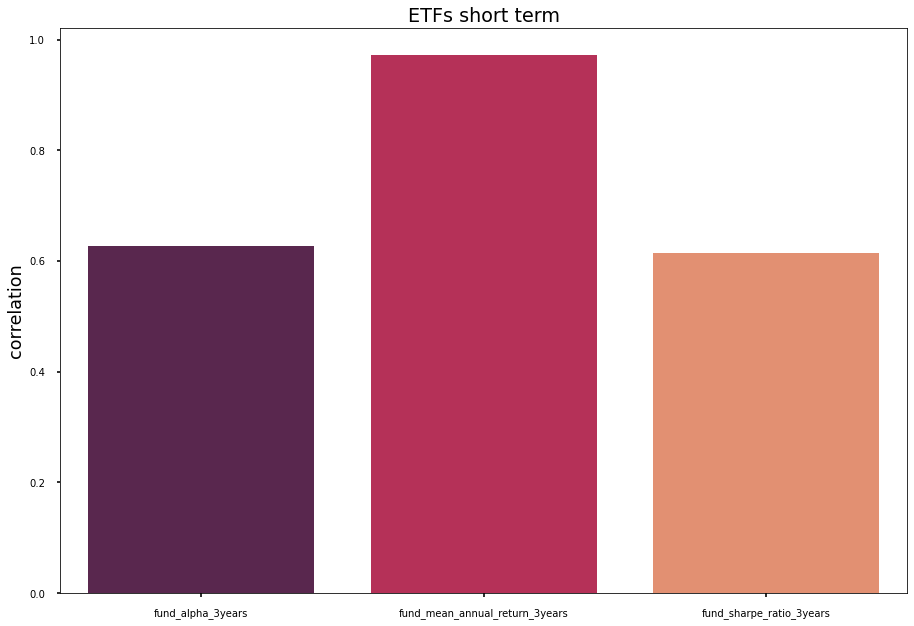

In [88]:
predictors=mf_short.columns.to_list()[2:]
print(predictors)
mf_short_corrs=get_correlations(mf_short,predictors,'fund_return_3years')
corr_visualize(mf_short_corrs,.1,'MFs short term',15)
plt.show()
print('\n')

predictors=etf_short.columns.to_list()[2:]
etf_short_corrs=get_correlations(etf_short,predictors,'fund_return_3years')
corr_visualize(etf_short_corrs,.1,'ETFs short term',10)

In [89]:
print(predictors)
predictors[2]

['fund_alpha_3years', 'fund_beta_3years', 'fund_mean_annual_return_3years', 'fund_r_squared_3years', 'fund_standard_deviation_3years', 'fund_sharpe_ratio_3years']


'fund_mean_annual_return_3years'

# MEDIUM TERM

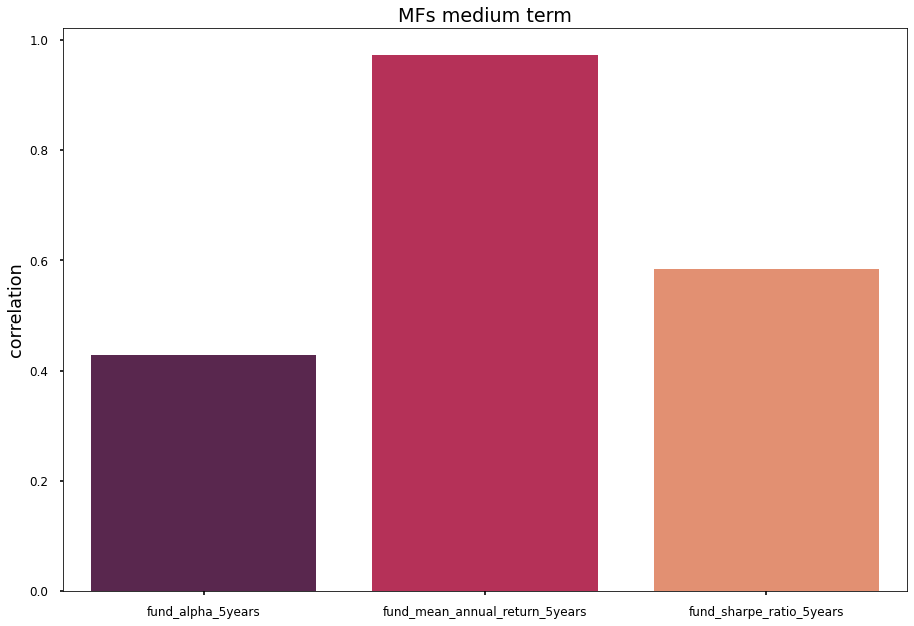

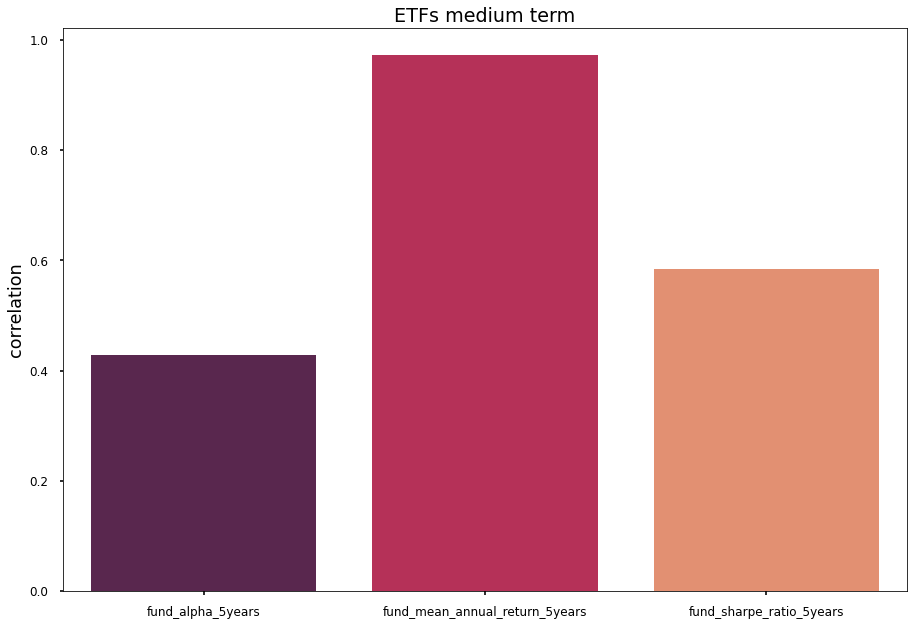

In [90]:
predictors=mf_med.columns.to_list()[2:]
mf_med_corrs=get_correlations(mf_med,predictors,'fund_return_5years')
corr_visualize(mf_med_corrs,.1,'MFs medium term',12)
plt.show()
print('\n')

predictors=etf_med.columns.to_list()[2:]
etf_med_corrs=get_correlations(etf_med,predictors,'fund_return_5years')
corr_visualize(etf_med_corrs,.1,'ETFs medium term',12)


# LONG TERM

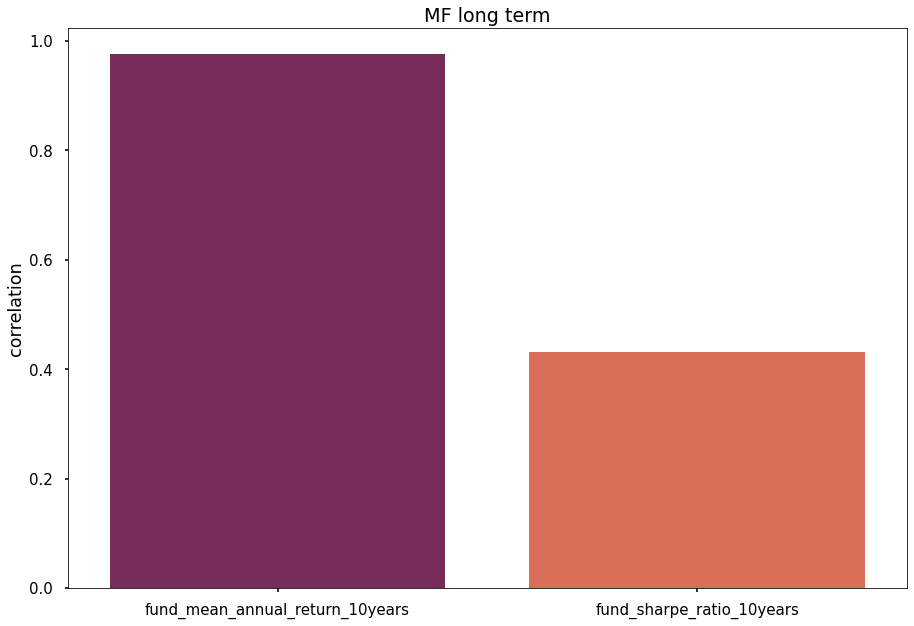

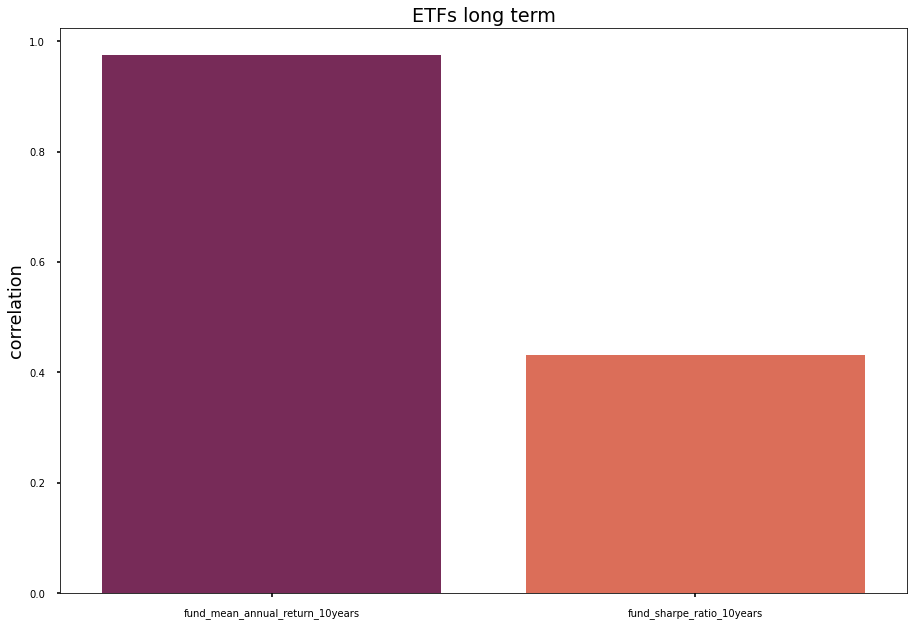

In [91]:
predictors=mf_long.columns.to_list()[2:]
mf_long_corrs=get_correlations(mf_long,predictors,'fund_return_10years')
corr_visualize(mf_long_corrs,.1,'MF long term',15)
plt.show()
print('\n')

predictors=etf_long.columns.to_list()[2:]
etf_long_corrs=get_correlations(etf_long,predictors,'fund_return_10years')
corr_visualize(etf_long_corrs,.1,'ETFs long term',10)

# using fund mean annual return  to predict fund return feels like cheating so we will not include it as a predictor variable going forward.


__putting all this together to see different time frames within each fund type:__

In [92]:
mf_short_corrs=mf_short_corrs.T.rename({'fund_alpha_3years':'fund_alpha','fund_beta_3years':'fund_beta','fund_mean_annual_return_3years':'fund_mean_annual_return','fund_r_squared_3years':'fund_r_squared','fund_standard_deviation_3years':'fund_standard_deviation','fund_sharpe_ratio_3years':'fund_sharpe_ratio','fund_treynor_ratio_3years':'fund_treynor_ratio'},axis='columns').T
etf_short_corrs=etf_short_corrs.T.rename({'fund_alpha_3years':'fund_alpha','fund_beta_3years':'fund_beta','fund_mean_annual_return_3years':'fund_mean_annual_return','fund_r_squared_3years':'fund_r_squared','fund_standard_deviation_3years':'fund_standard_deviation','fund_sharpe_ratio_3years':'fund_sharpe_ratio','fund_treynor_ratio_3years':'fund_treynor_ratio'},axis='columns').T
mf_short_corrs.head()

,correlation
fund_alpha,0.6263
fund_beta,0.0107
fund_mean_annual_return,0.9726
fund_r_squared,0.0161
fund_standard_deviation,0.0001


In [93]:
mf_med_corrs=mf_med_corrs.T.rename({'fund_alpha_5years':'fund_alpha','fund_beta_5years':'fund_beta','fund_mean_annual_return_5years':'fund_mean_annual_return','fund_r_squared_5years':'fund_r_squared','fund_standard_deviation_5years':'fund_standard_deviation','fund_sharpe_ratio_5years':'fund_sharpe_ratio','fund_treynor_ratio_3years':'fund_treynor_ratio'},axis='columns').T
etf_med_corrs=etf_med_corrs.T.rename({'fund_alpha_5years':'fund_alpha','fund_beta_5years':'fund_beta','fund_mean_annual_return_5years':'fund_mean_annual_return','fund_r_squared_5years':'fund_r_squared','fund_standard_deviation_5years':'fund_standard_deviation','fund_sharpe_ratio_5years':'fund_sharpe_ratio','fund_treynor_ratio_3years':'fund_treynor_ratio'},axis='columns').T
etf_med_corrs.head()

,correlation
fund_alpha,0.4290
fund_beta,0.0632
fund_mean_annual_return,0.9728
fund_r_squared,0.0429
fund_standard_deviation,0.0437


In [94]:
mf_long_corrs=mf_long_corrs.T.rename({'fund_alpha_10years':'fund_alpha','fund_beta_10years':'fund_beta','fund_mean_annual_return_10years':'fund_mean_annual_return','fund_r_squared_10years':'fund_r_squared','fund_standard_deviation_10years':'fund_standard_deviation','fund_sharpe_ratio_10years':'fund_sharpe_ratio','fund_treynor_ratio_3years':'fund_treynor_ratio'},axis='columns').T
etf_long_corrs=etf_long_corrs.T.rename({'fund_alpha_10years':'fund_alpha','fund_beta_10years':'fund_beta','fund_mean_annual_return_10years':'fund_mean_annual_return','fund_r_squared_10years':'fund_r_squared','fund_standard_deviation_10years':'fund_standard_deviation','fund_sharpe_ratio_10years':'fund_sharpe_ratio','fund_treynor_ratio_3years':'fund_treynor_ratio' },axis='columns').T
etf_long_corrs.head(10)

,correlation
fund_alpha,0.0894
fund_beta,0.0866
fund_mean_annual_return,0.9755
fund_r_squared,0.0728
fund_standard_deviation,0.0869
fund_sharpe_ratio,0.4315


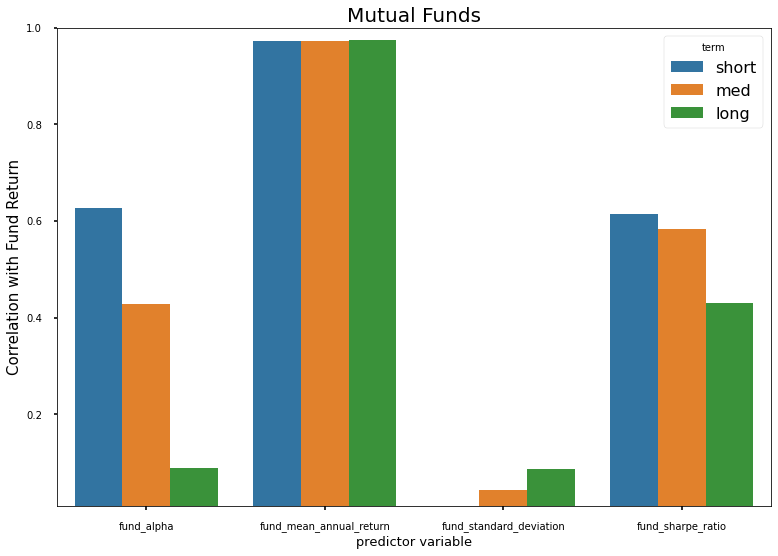

In [95]:

mf_short_corrs['term']='short'
etf_short_corrs['term']='short'


mf_med_corrs['term']='med'
etf_med_corrs['term']='med'

mf_long_corrs['term']='long'
etf_long_corrs['term']='long'



etf=pd.concat([etf_short_corrs,etf_med_corrs,etf_long_corrs])
mf=pd.concat([mf_short_corrs,mf_med_corrs,mf_long_corrs])

#Drops low correlated variables
mf.drop(labels=['fund_beta','fund_r_squared',], axis=0, inplace=True)
etf.drop(labels=['fund_beta','fund_r_squared',], axis=0, inplace=True)

b=sns.barplot(x=mf.index,y=etf['correlation'],data=mf,hue='term')
plt.tick_params(labelsize=10)

plt.title("Mutual Funds", fontsize = 20)
plt.xlabel("predictor variable", fontsize = 13)
plt.ylabel("Correlation with Fund Return", fontsize = 15)
b.set_ylim(.01, 1.0)
plt.show()


## Conclusion: We will stay away from using fund_mean_annual_return as a predictor because using fund returns to predict fund returns feels like cheating.

## __Implementing bootstrap sampling to reduce outlier bias.__

In [96]:
#Creates two new dataframes where only the highest correlated variables are stored
df_mf_highest_corrs=pd.DataFrame(index=['correlation'])
df_etf_highest_corrs=pd.DataFrame(index=['correlation'])

### __Method Used__

In [97]:
#To reduce influence of outliers, we implement bootstrap sampling and calculate the average correlation of multiple, normalized samples instead:
def bootstrap_correlations(df,predictors,index,num_trials,sample_size):
    df.dropna(subset=predictors,inplace=True)
    #creates new dataframe to store correlation data for each trial
    df_corr_trials=pd.DataFrame(index=np.arange(num_trials),columns=predictors)
    
    for i in range(num_trials):
        sample=df.sample(n=sample_size, replace=True)
        df_corr=get_correlations(sample,predictors,'fund_return_ytd')
        corr_col=df_corr.correlation
        for w in range(len(corr_col)):
            df_corr_trials.iloc[i,w]=corr_col[w]
    
    df_average_corrs=pd.DataFrame(index=['correlation'],columns=predictors)
    for col in df_corr_trials.columns:
        mean=df_corr_trials[col].mean()
        df_average_corrs.loc['correlation',col]=mean
    return df_average_corrs.T



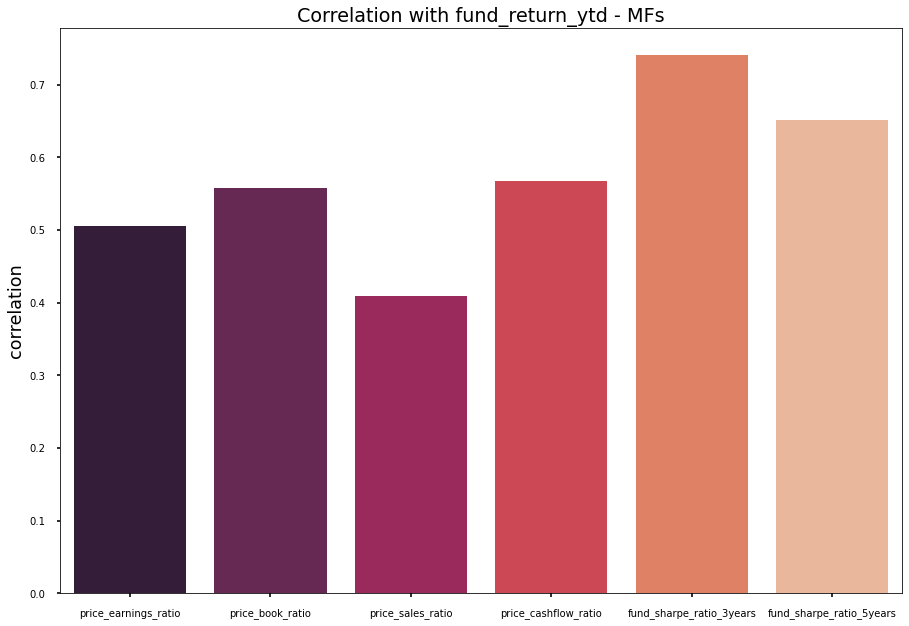

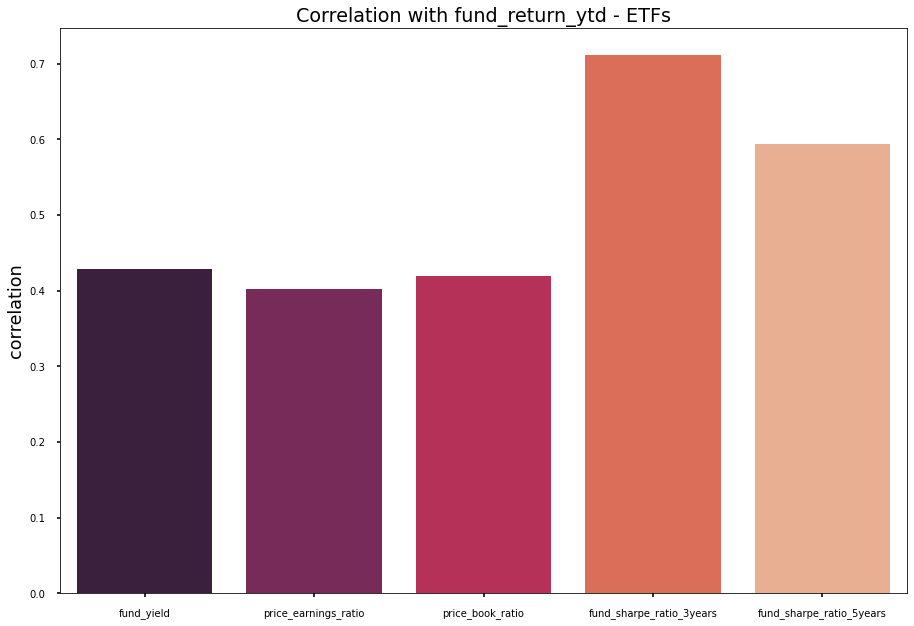

In [98]:
mf_joined=pd.merge(df_mf,df_mf_ratios)
etf_joined=pd.merge(df_etf,df_etf_ratios)
#joined.dropna(inplace=True)


predictors=['fund_yield',
            'fund_net_annual_expense_ratio',
            'price_earnings_ratio',
            'price_book_ratio',
            'price_sales_ratio',
            'price_cashflow_ratio',
            'fund_sharpe_ratio_3years',
            'fund_sharpe_ratio_5years',
            'fund_sharpe_ratio_10years',
           ]
mf_corrs=bootstrap_correlations(mf_joined,predictors,'fund_return_ytd',50,30)
etf_corrs=bootstrap_correlations(etf_joined,predictors,'fund_return_ytd',50,30)

filter_correlations(mf_corrs,df_mf_highest_corrs,.1)
filter_correlations(etf_corrs,df_etf_highest_corrs,.1)

corr_visualize(mf_corrs,.4,'Correlation with fund_return_ytd - MFs',10)
plt.show()
print('\n')
corr_visualize(etf_corrs,.4,'Correlation with fund_return_ytd - ETFs',10)


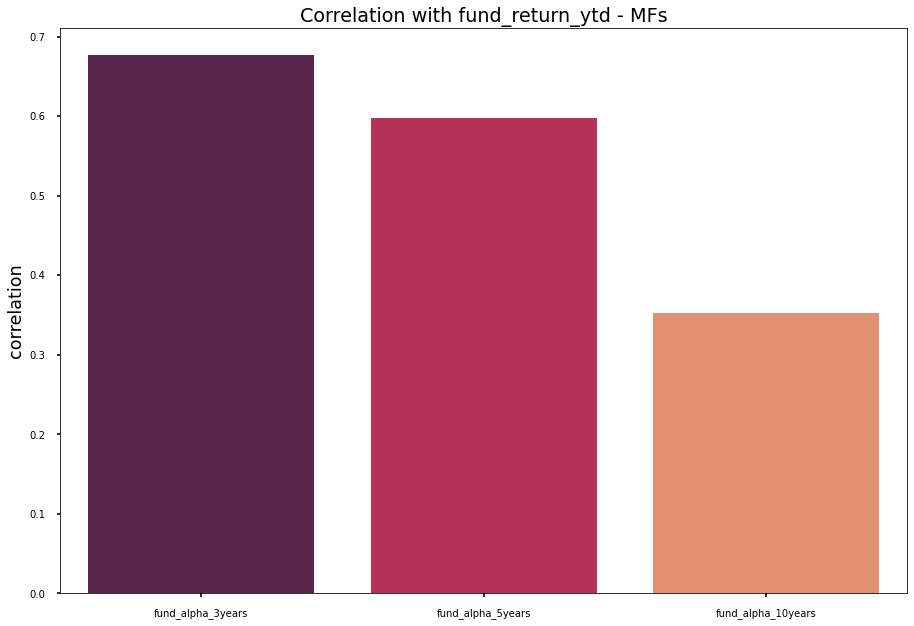

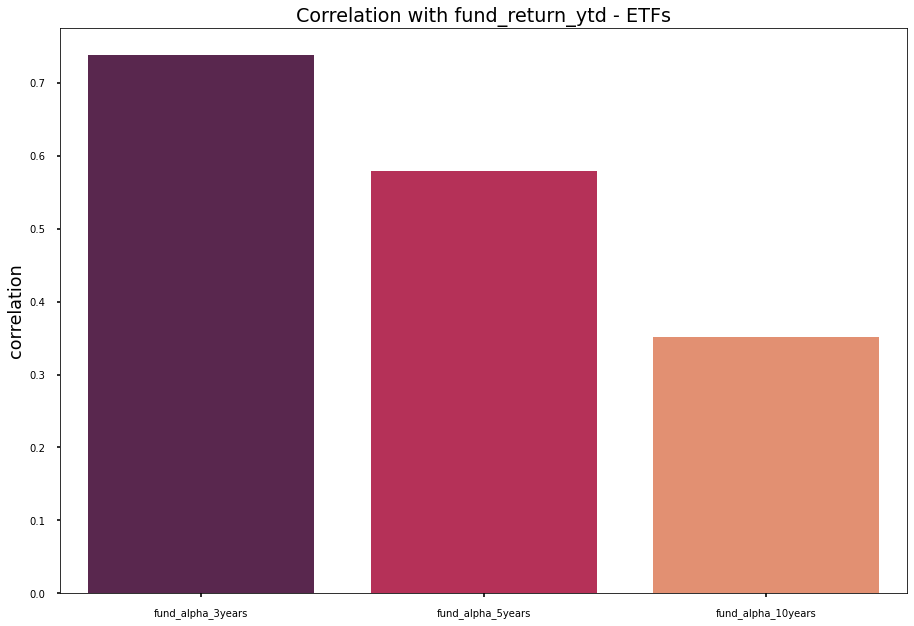

In [99]:
mf_joined=pd.merge(df_mf,df_mf_stats)
etf_joined=pd.merge(df_etf,df_etf_stats)
#joined.dropna(inplace=True)


predictors=['fund_alpha_3years',
            'fund_alpha_5years',
            'fund_alpha_10years'
           ]
mf_corrs=bootstrap_correlations(mf_joined,predictors,'fund_return_ytd',50,30)
etf_corrs=bootstrap_correlations(etf_joined,predictors,'fund_return_ytd',50,30)

filter_correlations(mf_corrs,df_mf_highest_corrs,.1)
filter_correlations(etf_corrs,df_etf_highest_corrs,.1)

corr_visualize(mf_corrs,.2,'Correlation with fund_return_ytd - MFs',10)
plt.show()
print('\n')
corr_visualize(etf_corrs,.2,'Correlation with fund_return_ytd - ETFs',10)


# using fund mean annual return  to predict fund return feels like cheating so we will not include it as a predictor variable going forward.


In [100]:
df_mf_highest_corrs.head(10)

,fund_yield,price_earnings_ratio,price_book_ratio,price_sales_ratio,price_cashflow_ratio,fund_sharpe_ratio_3years,fund_sharpe_ratio_5years,fund_sharpe_ratio_10years,fund_alpha_3years,fund_alpha_5years,fund_alpha_10years
correlation,0.204544,0.505736,0.55802,0.409348,0.567518,0.741088,0.651294,0.34759,0.677108,0.596984,0.35173


**We observe that compared to classic lin reg, the bootstrap correlations tend to have slightly different correlations. In particular, highly correlated variables have their influence reduced and mid/low correlated variables have the correlations slightly exaggerated.**

# Creating our own variable to measure fund returns

In [101]:
df_mf_highest_corrs=df_mf_highest_corrs.T.sort_values(by=['correlation'],ascending=False)
df_etf_highest_corrs=df_etf_highest_corrs.T.sort_values(by=['correlation'],ascending=False)
df_mf_highest_corrs.head(10)

,correlation
fund_sharpe_ratio_3years,0.741088
fund_alpha_3years,0.677108
fund_sharpe_ratio_5years,0.651294
fund_alpha_5years,0.596984
price_cashflow_ratio,0.567518
price_book_ratio,0.558020
price_earnings_ratio,0.505736
price_sales_ratio,0.409348
fund_alpha_10years,0.351730
fund_sharpe_ratio_10years,0.347590


In [102]:
df_etf_highest_corrs.head(10)

,correlation
fund_alpha_3years,0.738818
fund_sharpe_ratio_3years,0.711934
fund_sharpe_ratio_5years,0.594058
fund_alpha_5years,0.578734
fund_yield,0.428152
price_book_ratio,0.419440
price_earnings_ratio,0.402576
price_cashflow_ratio,0.397154
fund_alpha_10years,0.351032
fund_sharpe_ratio_10years,0.275318


In [103]:
#first instance of df_mf3,df_etf3
df_mf3=pd.read_csv('USData/Mutual Funds.csv')
df_etf3=pd.read_csv('USData/ETFs.csv')
etf_vars=df_etf_highest_corrs.sort_values(by=['correlation'],ascending=False).index[:5]
mf_vars=df_mf_highest_corrs.sort_values(by=['correlation'],ascending=False).index[:5]

df_mf3[mf_vars]=StandardScaler().fit_transform(df_mf3[mf_vars])
df_etf3[etf_vars]=StandardScaler().fit_transform(df_etf3[etf_vars])

df_mf3['fund_return_ytd']=StandardScaler().fit_transform(df_mf3[['fund_return_ytd']])
df_etf3['fund_return_ytd']=StandardScaler().fit_transform(df_etf3[['fund_return_ytd']])

df_mf3['category_return_ytd']=StandardScaler().fit_transform(df_mf3[['category_return_ytd']])
df_etf3['category_return_ytd']=StandardScaler().fit_transform(df_etf3[['category_return_ytd']])

df_mf3['score']=0
df_etf3['score']=0

for var in mf_vars:   
    mf_score=df_mf3[var]*(df_mf_highest_corrs.loc[var,'correlation'])
    df_mf3['score']+=mf_score
    #print(mf_score)


for var in etf_vars:   
    etf_score=df_etf3[var]*(df_etf_highest_corrs.loc[var,'correlation'])
    df_etf3['score']+=etf_score
    #print(etf_score)

mf_cols=df_mf.columns.to_list()
mf_cols.extend(mf_vars)
mf_cols.append('score')
mf_clean=pd.DataFrame()
for col in mf_cols:
    mf_clean[col]=df_mf3[col]

etf_cols=df_etf.columns.to_list()
etf_cols.extend(etf_vars)
etf_cols.append('score')
etf_clean=pd.DataFrame()
for col in etf_cols:
    etf_clean[col]=df_etf3[col]

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (167,171) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Hypothesis test: is the new score variable significant?

In [104]:
#Hypothesis Test
etf_clean.head()

,fund_symbol,fund_extended_name,fund_family,inception_date,category,investment_strategy,investment_type,size_type,fund_yield,fund_return_ytd,fund_alpha_3years,fund_sharpe_ratio_3years,fund_sharpe_ratio_5years,fund_alpha_5years,score
0,1305,Daiwa ETF TOPIX,Daiwa Asset Management Co Ltd,2001-07-11,NaN,The investment seeks to track the price and yi...,Blend,Large,-0.273130,-0.169020,0.268787,0.347257,0.839227,0.233228,0.962394
1,1306,Nomura TOPIX ETF,Nomura Asset Management Co Ltd,2001-07-11,NaN,The investment seeks to track the price and yi...,Blend,Large,-0.304286,-0.158201,0.271376,0.347257,0.839227,0.234881,0.951924
2,1308,Nikko Exchange Traded Index TOPIX,Nikko Asset Management Co Ltd,2001-12-20,NaN,The investment seeks to track the price and yi...,Blend,Large,-0.273130,-0.160479,0.270082,0.347257,0.839227,0.236535,0.965264
3,1310,Daiwa ETF TOPIX Core 30,Daiwa Asset Management Co Ltd,2002-03-28,NaN,The investment seeks to track the price and yi...,Blend,Large,0.051775,-0.173005,-0.102654,-0.161107,0.115232,-0.395038,-0.328540
4,1311,Nomura TOPIX Core 30 ETF,Nomura Asset Management Co Ltd,2002-04-02,NaN,The investment seeks to track the price and yi...,Blend,Large,-0.282032,-0.187240,-0.100066,-0.161107,0.115232,-0.391732,-0.467634


# Logistic Regression to see if our variable accuractely predicts fund_return

In [105]:
#Adds category ytd fund return column to main dataframes
mf_clean['category_return_ytd']=df_mf_category_data['category_return_ytd']
etf_clean['category_return_ytd']=df_etf_category_data['category_return_ytd']
mf_clean.dropna(inplace=True)
etf_clean.dropna(inplace=True)
mf_clean.shape


(12128, 23)

In [106]:
#Adding column to MF dataframe that tells whether it is above average return
ytd_index=mf_clean.columns.get_loc('fund_return_ytd')
cat_ytd_index=mf_clean.columns.get_loc('category_return_ytd')

greater_list=[]
for i in range(mf_clean.shape[0]):
    if (mf_clean.iloc[i,ytd_index]< mf_clean.iloc[i,cat_ytd_index]):
        greater_list.append(0)
    else:
        greater_list.append(1)

mf_clean['>average']=greater_list
mf_clean['>average'].head(30)


0     1
1     0
2     0
3     1
4     1
5     1
6     1
7     1
8     1
9     0
10    1
11    1
12    1
13    1
14    1
15    0
16    0
18    0
20    0
21    1
22    0
23    1
25    1
26    1
27    1
28    1
29    0
30    1
31    0
32    1
Name: >average, dtype: int64

In [107]:
#Adding column to ETF dataframe that tells whether it is above average return
ytd_index=etf_clean.columns.get_loc('fund_return_ytd')
cat_ytd_index=etf_clean.columns.get_loc('category_return_ytd')

greater_list=[]
for i in range(etf_clean.shape[0]):
    if (etf_clean.iloc[i,ytd_index]< etf_clean.iloc[i,cat_ytd_index]):
        greater_list.append(0)
    else:
        greater_list.append(1)

etf_clean['>average']=greater_list
etf_clean['>average'].head(20)

116    0
117    0
120    0
121    0
122    0
123    0
124    0
125    0
127    0
128    0
129    0
134    0
135    0
137    0
138    0
140    0
141    0
142    0
143    0
144    0
Name: >average, dtype: int64

In [108]:
def log_prob(df,predictor):
    df[predictor]=StandardScaler().fit_transform(df[[predictor]])
    df=df.loc[df[predictor]<4.5]

    #df=df.loc[df['category']=='World Allocation']
    #df=df.groupby('category')
    X_train, X_test, y_train, y_test = train_test_split(df[[predictor]], df['>average'], test_size=0.4)
    logit=LogisticRegression().fit(X_train,y_train)
    

    #Calculate expected probability of above average return and save as y_pred variable
    y_prob=logit.predict_proba(X_test)[:,1]
    
    #Predict 0,1 for train data and save to variable
    y_pred=logit.predict(X_test)

    
    #Calculates % Accuracy
    num_correct=0
    length=len(y_pred)
    for i in range(length):
        if y_pred[i]==y_test.iloc[i]:
            num_correct=num_correct+1
    accuracy=num_correct/length
    
    #Print summary statistics
    print('Predictors: {}'.format(predictor))
    print('The log reg model predicts whether fund return is above average with an accuracy of {:.3f}'.format(accuracy))
    print('The R-squared value is {:.3f}'.format(logit.score(X_train,y_train)))

    #Draws scatterplots of predicted probability and actual 0,1 values
    plt.scatter(x=X_test[predictor],y=y_prob,alpha=0.5,c='orange')
    plt.scatter(x=X_test[predictor],y=y_test,alpha=0.3)
    plt.tight_layout()



Predictors: score
The log reg model predicts whether fund return is above average with an accuracy of 0.668
The R-squared value is 0.670


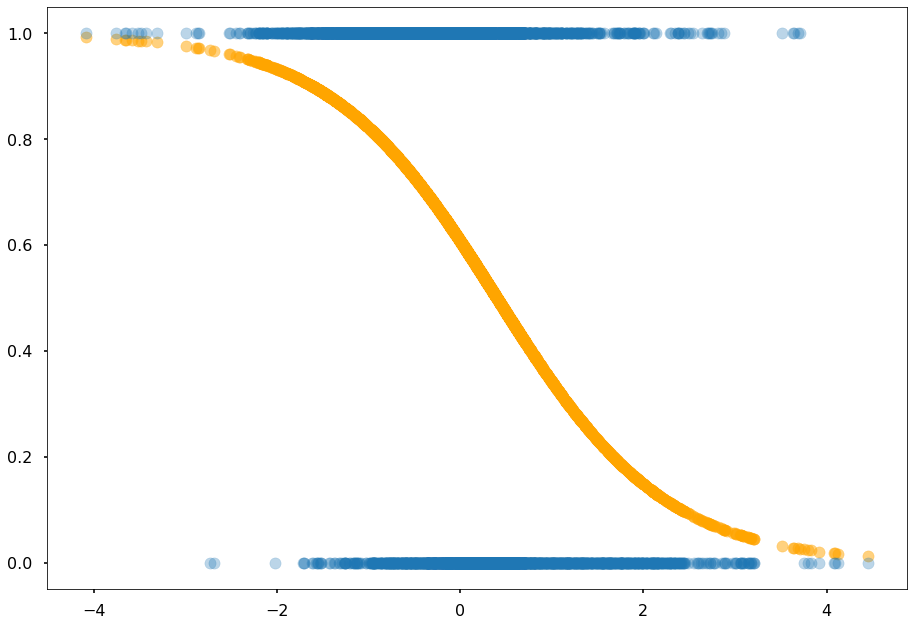



Predictors: score
The log reg model predicts whether fund return is above average with an accuracy of 0.909
The R-squared value is 0.900


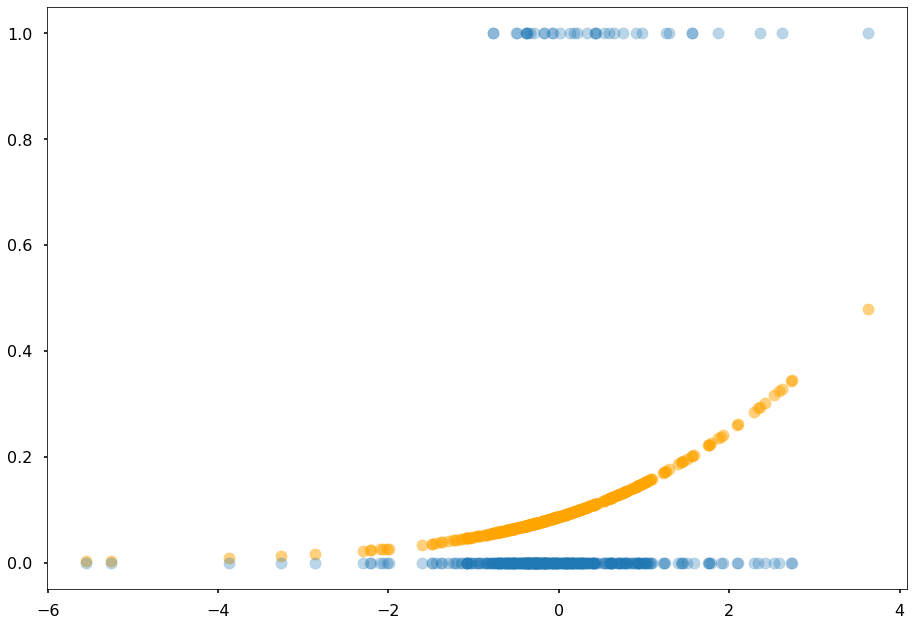

In [125]:
mf_clean.dropna(inplace=True)
log_prob(mf_clean,'score')
plt.show()
print('\n')
etf_clean.dropna(inplace=True)
log_prob(etf_clean,'score')

Predictors: fund_sharpe_ratio_3years
The log reg model predicts whether fund return is above average with an accuracy of 0.649
The R-squared value is 0.656


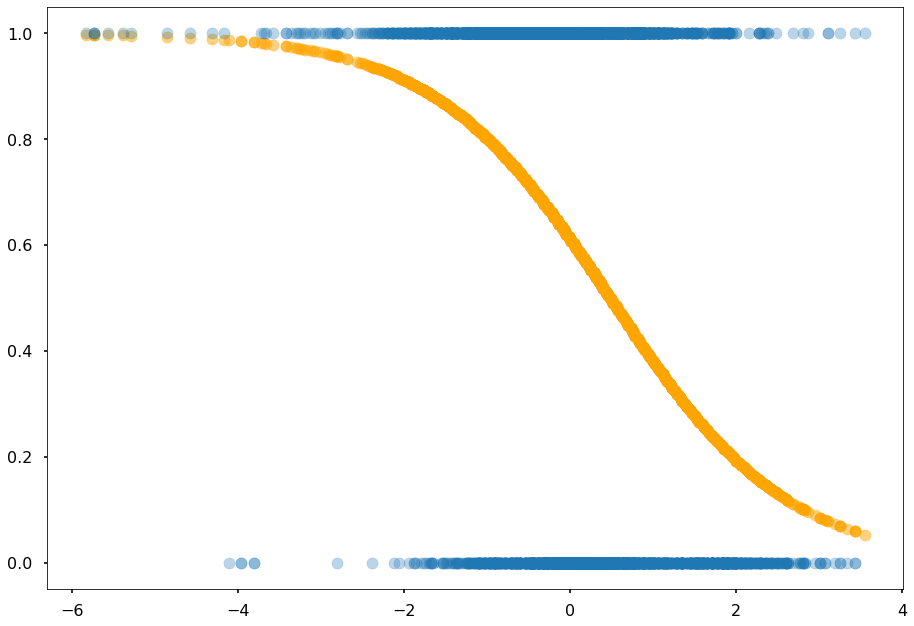



Predictors: fund_sharpe_ratio_3years
The log reg model predicts whether fund return is above average with an accuracy of 0.891
The R-squared value is 0.912


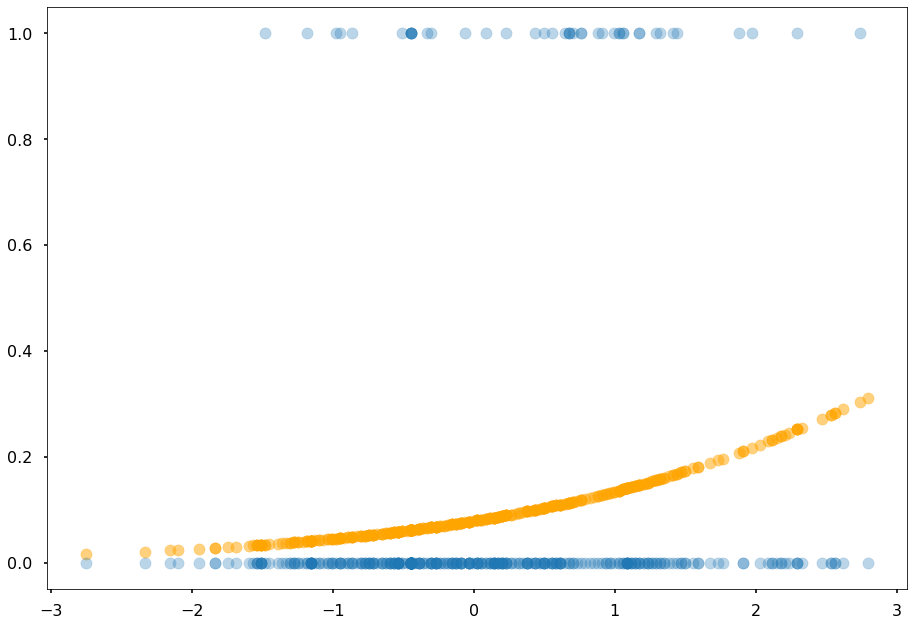

In [126]:
#Predicting by sharpe_ratio_3years
log_prob(mf_clean,'fund_sharpe_ratio_3years')
plt.show()
print('\n')
log_prob(etf_clean,'fund_sharpe_ratio_3years')

## Analysis of Categorical Variables

In [114]:
#Function that uses get_dummies to calculate the correlations of categorical columns such as size_type 
def categorical_corrs(df,dummycols,index):
    df.dropna(subset=dummycols,inplace=True)
    df_dummies=df
    dummy_list=[]
    for dummycol in dummycols:
        dummy_list.extend(df[dummycol].unique())
        dummy_df=pd.get_dummies(df[dummycol])
        df_dummies=df_dummies.join(dummy_df)
    df_cat_corrs=bootstrap_correlations(df_dummies,dummy_list,'fund_return_ytd',100,60)
    return df_cat_corrs

Text(0.5, 1.0, 'size_type correlations with fund_return_ytd')

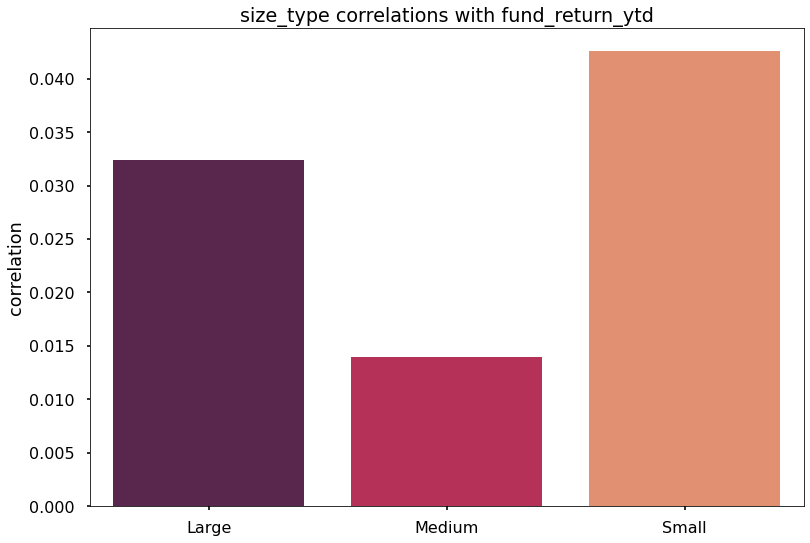

In [127]:
#Start of Binary Variable Analysis
df_sizes=df_mf.join(pd.get_dummies(df_mf['size_type']))
df_sizes.head()
df_sizes.dropna(subset=['size_type','fund_return_ytd'],inplace=True)

# scale our data
cols=['median_market_cap', 'bond_maturity', 'bond_duration', 'fund_yield','fund_return_ytd']
scaled = StandardScaler().fit_transform(df_sizes[cols])
df_sizes[cols]=scaled

corrs=bootstrap_correlations(df_sizes,['Large','Medium','Small'],'fund_return_ytd',100,50)
sns.barplot(x=corrs.index,y=corrs.correlation,palette='rocket')
plt.title('size_type correlations with fund_return_ytd')

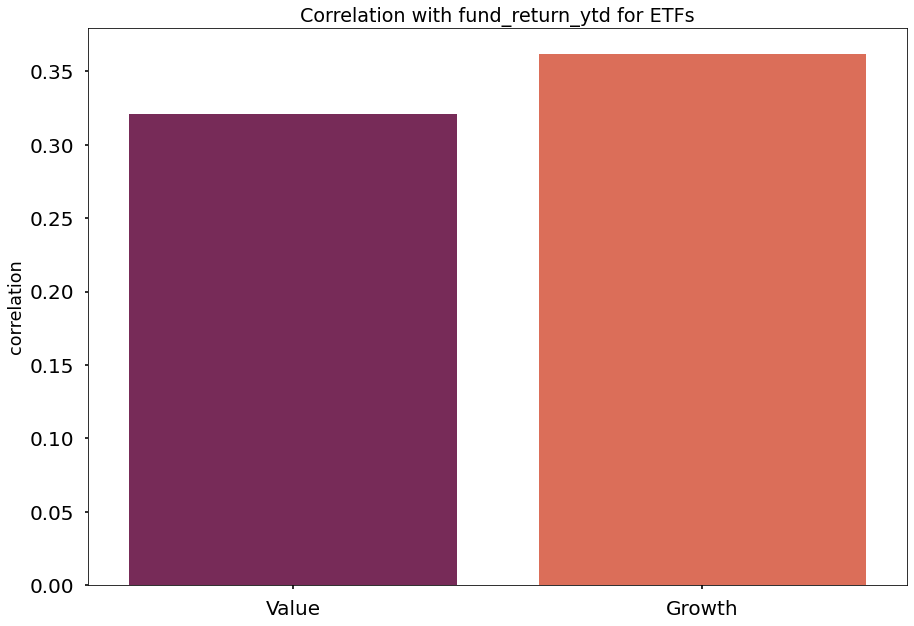

In [116]:
#Example of using categorical_corrs function to see which size/investment types are most correlated with fund return
etf_corrs=categorical_corrs(df_etf,['size_type','investment_type'],'fund_return_ytd')
corr_visualize(etf_corrs,.05,'Correlation with fund_return_ytd for ETFs',20)

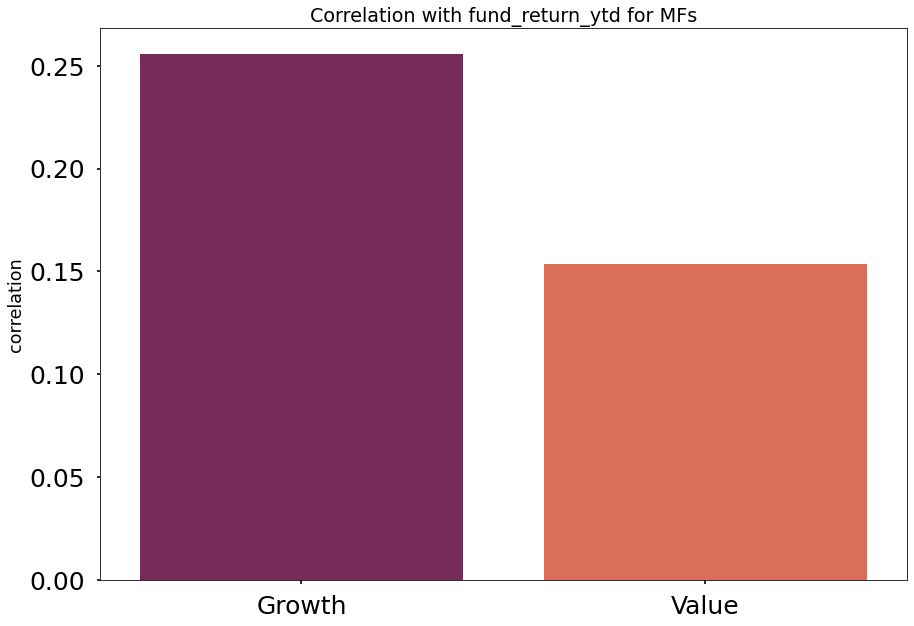

In [117]:
#Same as previous cell except for MFs
mf_corrs=categorical_corrs(df_mf,['size_type','investment_type'],'fund_return_ytd')
corr_visualize(mf_corrs,.05,'Correlation with fund_return_ytd for MFs',25)

**As we can see from the above code cell, for both MFs and ETFs, an investment type of growth or value is shown to significantly improve fund return when compared to an investment type of blend. Furthermore, we see that fund size has little influence of fund performance.**

In [ ]:
**Emilys part about growth**

# Re-running logreg only on Growth funds


Predictors: score
The log reg model predicts whether fund return is above average with an accuracy of 0.792
The R-squared value is 0.797


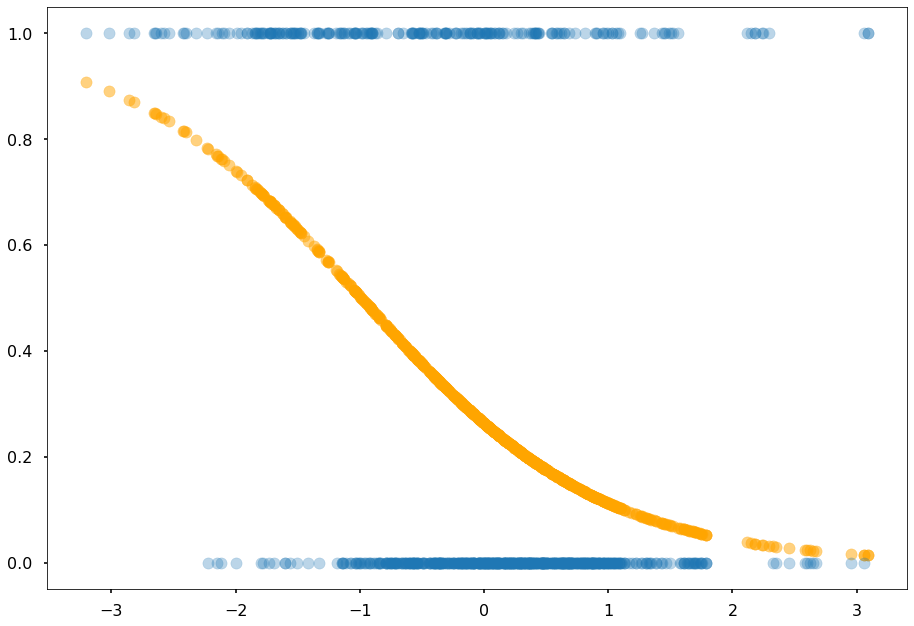

In [118]:
mf_growth=mf_clean.loc[mf_clean['investment_type']=='Growth'].dropna()
log_prob(mf_growth,'score')


Predictors: score
The log reg model predicts whether fund return is above average with an accuracy of 0.825
The R-squared value is 0.797


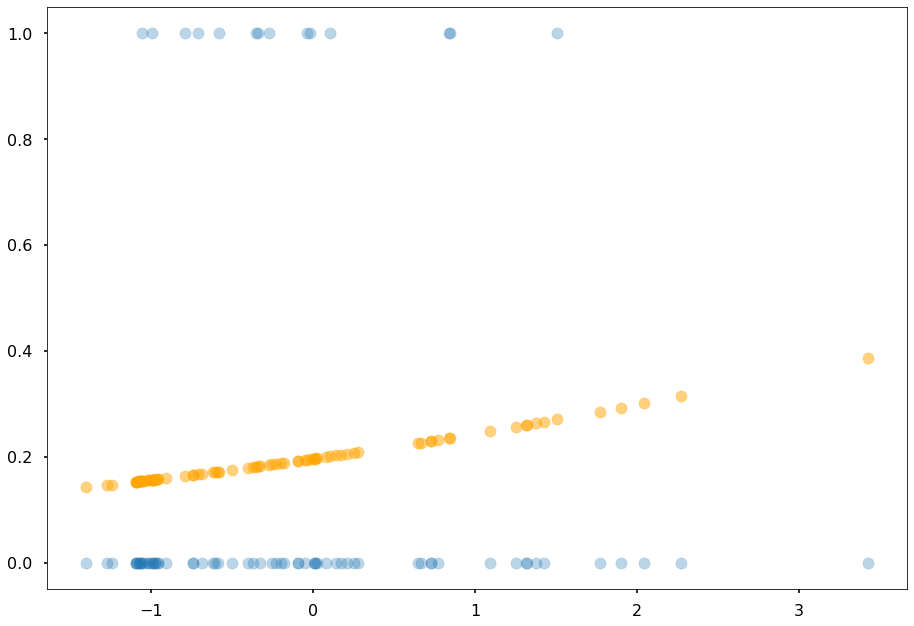

In [119]:
etf_growth=etf_clean.loc[etf_clean['investment_type']=='Growth'].dropna()
log_prob(etf_growth,'score')


## Analyzing exclusively growth funds gave varying results. Amongst Mutual Funds, we saw 15% increase in accuracy as a result of this. Amongst ETFs, accuracy dropped by ~15% when exclusively growth funds were used. Initially, we thought this was because only MFs were benefitted 

# ___Conclusions___:

**We observe that compared to classic lin reg, the bootstrap correlations tend to have slightly different correlations. In particular, highly correlated variables have their influence reduced and mid/low correlated variables have the correlations slightly exaggerated.**

**We observe that growth funds tend to outperform value/blend funds. Furthermore, we observe that growth funds tend to be less variable.**

# Ideas for the future (phase V):

Hypothesis test,
more insightful modeling (incorporating additional variables such as fund_family and inception date), 
more accurate modeling (improving performance), 
more types of modeling (random forest, eg.)